# Search for Gravitational Waves in LIGO data

In this exercise we will replicate in simplified form the kind of data analysis that LIGO does when it searches it's data for gravitational wave signals from outer space.

We use a technique called *matched filtering* whereby we take an example of the signal we expect to detect, which we call a *template*, and make a filter that can be used to comb through data to look for things that look just like the template.

Matched filtering is a powerful technique, which means that it's a little bit advanced to implement.  You might not get all the details, but try to follow the general outline.

We'll see examples of object-oriented programming in this exercise as well.

### Load needed libraries

Usually at the top of your program you will *import* all the libraries you'll need to use in the program.

In [1]:
# Standard python numerical analysis imports:
import numpy as np
from scipy import signal
from scipy.interpolate import interp1d
from scipy.signal import butter, filtfilt, iirdesign, zpk2tf, freqz
import h5py
import json

# the IPython magic below must be commented out in the .py file, since it doesn't work there.
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab

## Define filtering classes

In this section we'll create three Filter class that we'll need to use to do the search.

### Filter base class

This is the base/parent/super class from which all other filter classes will inherit.

It only defines one method, `filter_data`, that all filters must have.

In [2]:
class Filter(object):
    def filter_data(self, data, fs):
        """filter the data `data` with sample rate `fs`

        This will return the filtered data array.
        
        """
        pass
    

### Whitening filter

A *whitening filter* is a special kind of filter that removes any "features" from data and makes the data look like "white noise".

When you "whiten" data you divide it by the noise amplitude spectrum in the fourier domain (don't worry about exactly what this means right now).  It has the affect of suppressing any extra noise at low frequencies, or at spectral lines, and allows us to better see weak signals in the data.

Whitening is always one of the first steps in astrophysical data analysis searches.
Whitening requires no prior knowledge of spectral lines, etc; only the data are needed.

The resulting time series is no longer in units of strain; now in units of "sigmas" away from the mean.

We will plot the whitened strain data, along with the signal template, after the matched filtering section, below.

In [3]:
class WhiteningFilter(Filter):
    def __init__(self, data, fs):
        """Initialize class with the data that will be used as the basis for
        whitening, `data`, and it's sample rate, `fs`.
    
        """
        # number of sample for the fast fourier transform:
        NFFT = 4*fs
        # calculate the power spectral density (psd) of the data
        Pxx, freqs = mlab.psd(data, Fs=fs, NFFT=NFFT)
        # create an interpolation function for the psd
        self.interp_psd = interp1d(freqs, Pxx)
        
    def filter_data(self, data, fs):
        """filter data `data` with sample rate `fs`

        This will return the filtered data array.
        
        """
        # number of data points
        Nt = len(data)
        df = 1./fs

        # make a new frequency array for fft below
        freqs = np.fft.rfftfreq(Nt, dt)
        
        # make the "fast fourier transform" of the data
        hf = np.fft.rfft(data)

        # divide the fft by amplitude spectral density (asd = sqrt(psd))
        white_hf = hf / (np.sqrt(self.interp_psd(freqs) / dt / 2.))
        # transform frequency array back to time array with inverse fft (ifft)
        white_ht = np.fft.irfft(white_hf, n=Nt)

        return white_ht

### band pass filter

A *band pass filter* is used to filter out any frequencies from the data that are not in a specified region of interest.

In [4]:
class BandPassFilter(object):
    def __init__(self, fband):
        """To make a band pass filter we only need to know the band to pass,
        which is specified by the `fband` tuple of the form (fstart, fstop).

        """
        self.fband = fband
        
    def filter_data(self, data, fs):
        """filter data `data` with sample rate `fs`

        This will return the filtered data array.
        
        """
        bb, ab = butter(4, [self.fband[0]*2./fs, self.fband[1]*2./fs], btype='band')
        return filtfilt(bb, ab, data)

### Matched filter

Matched filtering is the optimal way to find a known signal buried in noise. It is the standard technique used by the gravitational wave community to find gravitational wave signals from compact binary mergers in LIGO's noisy detector data.

For some loud signals, it may be possible to see the signal in the whitened data or in spectrograms (see extra credit). On the other hand, low signal-to-noise ratio (SNR) signals or signals which are of long duration in time may not be visible, even in the whitened data.  LIGO scientists use matched filtering to find such "hidden" signals. A matched filter works by compressing the entire signal into one time bin (by convention, the "end time" of the waveform).

LIGO uses a rather elaborate software suite to match the data against a family of such signal waveforms ("templates"), to find the best match. This procedure helps to "optimally" separate signals from instrumental noise, and to infer the parameters of the source (masses, spins, sky location, orbit orientation, etc) from the best match templates. 

A blind search requires us to search over many compact binary merger templates (eg, 250,000) with different masses and spins, as well as over all times in all detectors, and then requiring triggers coincident in time and template between detectors. It's an extremely complex and computationally-intensive "search pipeline".

Here, we simplify things, using only one template (the one identified in the full search as being a good match to the data). 

Assuming that the data around this event is fairly Gaussian and stationary, we'll use this simple method to identify the signal (matching the template) in our 32 second stretch of data. The peak in the SNR vs time is a "single-detector event trigger".

This calculation is described in section IV of:
FINDCHIRP: An algorithm for detection of gravitational waves from inspiraling compact binaries
B. Allen et al., PHYSICAL REVIEW D 85, 122006 (2012) ; http://arxiv.org/abs/gr-qc/0509116

The full search procedure is described in
GW150914: First results from the search for binary black hole coalescence with Advanced LIGO,
The LIGO Scientific Collaboration, the Virgo Collaboration, http://arxiv.org/abs/1602.03839

In [5]:
class MatchedFilter(object):
    def __init__(self, template, fs):
        """Matched filters are defined by a template.

        `template` is a complex waveform template array with sample rate `fs`.
        
        """
        self.template = template
        self.template_fs = fs

        # to remove effects at the beginning and end of the data stretch, window the data
        # https://en.wikipedia.org/wiki/Window_function#Tukey_window
        dwindow = signal.tukey(self.template.size, alpha=1./8)

        # prepare the template fft interpolant
        self.freqs = np.fft.fftfreq(template.size) * fs
        self.template_fft = np.fft.fft(template*dwindow) / fs

    def filter_data(self, data, fs):
        """filter data `data` with sample rate `fs`

        This will return the complex "SNR time series" from the matched filter,
        and the "sigma" array, which is the standard deviation of the noise.
        
        """
        NFFT = 4*fs
        WINDOW = np.blackman(NFFT)
        # and a 50% overlap:
        NOVL = NFFT/2

        # Calculate the PSD of the data.  Also use an overlap, and window
        data_psd, freqs = mlab.psd(data,
                                   Fs=fs,
                                   NFFT=NFFT,
                                   window=WINDOW,
                                   noverlap=NOVL)

        df = np.abs(self.freqs[1] - self.freqs[0])

        # Take the Fourier Transform (FFT) of the data
        dwindow = signal.tukey(data.size, alpha=1./8)
        data_fft = np.fft.fft(data*dwindow) / fs

        # Interpolate to get the PSD values at the needed frequencies
        power_vec = np.interp(np.abs(self.freqs), freqs, data_psd)

        # -- Calculate the matched filter output in the time domain
        # Multiply the Fourier Space template and data, and divide by the noise power in each frequency bin.
        optimal = data_fft * self.template_fft.conjugate() / power_vec
        # Take the Inverse Fourier Transform (IFFT) of the filter output to put it back in the time domain
        optimal_time = 2*np.fft.ifft(optimal) * fs

        # -- Normalize the matched filter output:
        # Normalize the matched filter output so that we expect a value of 1 at times of just noise.
        # Then, the peak of the matched filter output will tell us the signal-to-noise ratio (SNR) of the signal.
        sigmasq = 1*(self.template_fft * self.template_fft.conjugate() / power_vec).sum() * df
        sigma = np.sqrt(np.abs(sigmasq))
        SNR_complex = optimal_time / sigma

        # shift the SNR vector by the template length so that the peak is at the END of the template
        peaksample = int(data.size / 2)
        SNR_complex = np.roll(SNR_complex, peaksample)

        return SNR_complex, sigma

## Read in the LIGO data

Here we read in the LIGO data (data that includes a gravitational wave signal!) from a file on disk.

The file is in a special format called "hdf5".  Let's start by making a special function to load the data from a file and return the data and time arrays.

In [6]:
def load_ligo_data(file_path):
    with h5py.File(file_path, 'r') as f:
        strain = f['strain']['Strain'][:]
        time = np.arange(len(strain)) * f['strain']['Strain'].attrs['Xspacing'] + f['meta']['GPSstart']
    return strain, time

In [7]:
strain, time = load_ligo_data('H-H1_LOSC_4_V1-1126259446-32.hdf5')

# we'll need the sample time step and frequency
dt = time[1] - time[0]
fs = int(1./dt)

### Plot the data

Before we do the search, let's just take a quick look at the data.  

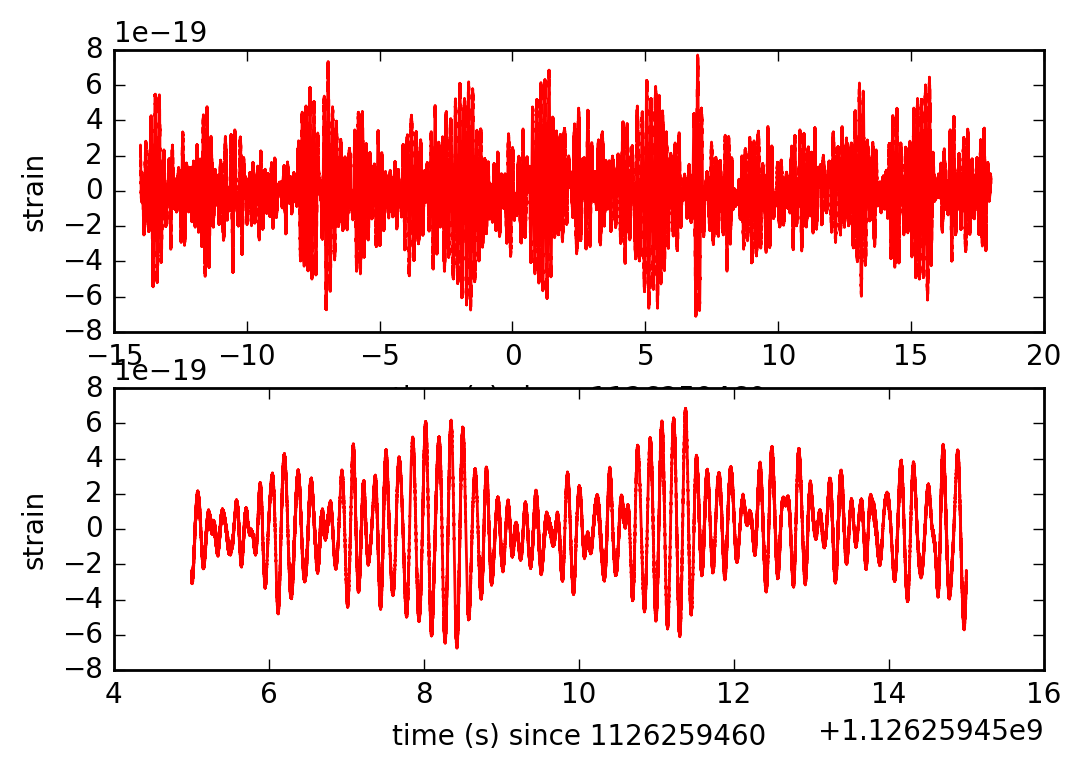

In [8]:
plt.figure()

tref = 1126259460

plt.subplot(2,1,1)
plt.plot(time-tref, strain, 'r', label='strain')
plt.xlabel('time (s) since '+str(tref))
plt.ylabel('strain')

# now zoom in around the middle
deltat = 5
indxt = np.where((time >= tref-deltat) & (time < tref+deltat))

plt.subplot(2,1,2)
plt.plot(time[indxt], strain[indxt], 'r', label='strain')
plt.xlabel('time (s) since '+str(tref))
plt.ylabel('strain')

## Waveform Template

Here we load a *template* from a file.  The template is what we think the gravitational wave signal will look like.

First create a function to load templates from files.  We'll need this to load different templates later.

In [9]:
def load_template(file_name):
    """load gravitational wave template from a file
    
    returns the complex template array, and the corresponding time array.
    
    """
    with h5py.File(file_name, "r") as f:
        template_p, template_c = f["template"][...]
        
    # the templates extends to roughly 16s, zero-padded to the 32s data length. The merger will be roughly 16s in.
    template_offset = 16.
    
    # complex template:
    template = (template_p + template_c*1.j) 
    ttime = time-time[0]-template_offset
    
    return template, ttime

now load the template

In [10]:
template, ttime = load_template('GW150914_4_template.hdf5') 

now plot the template

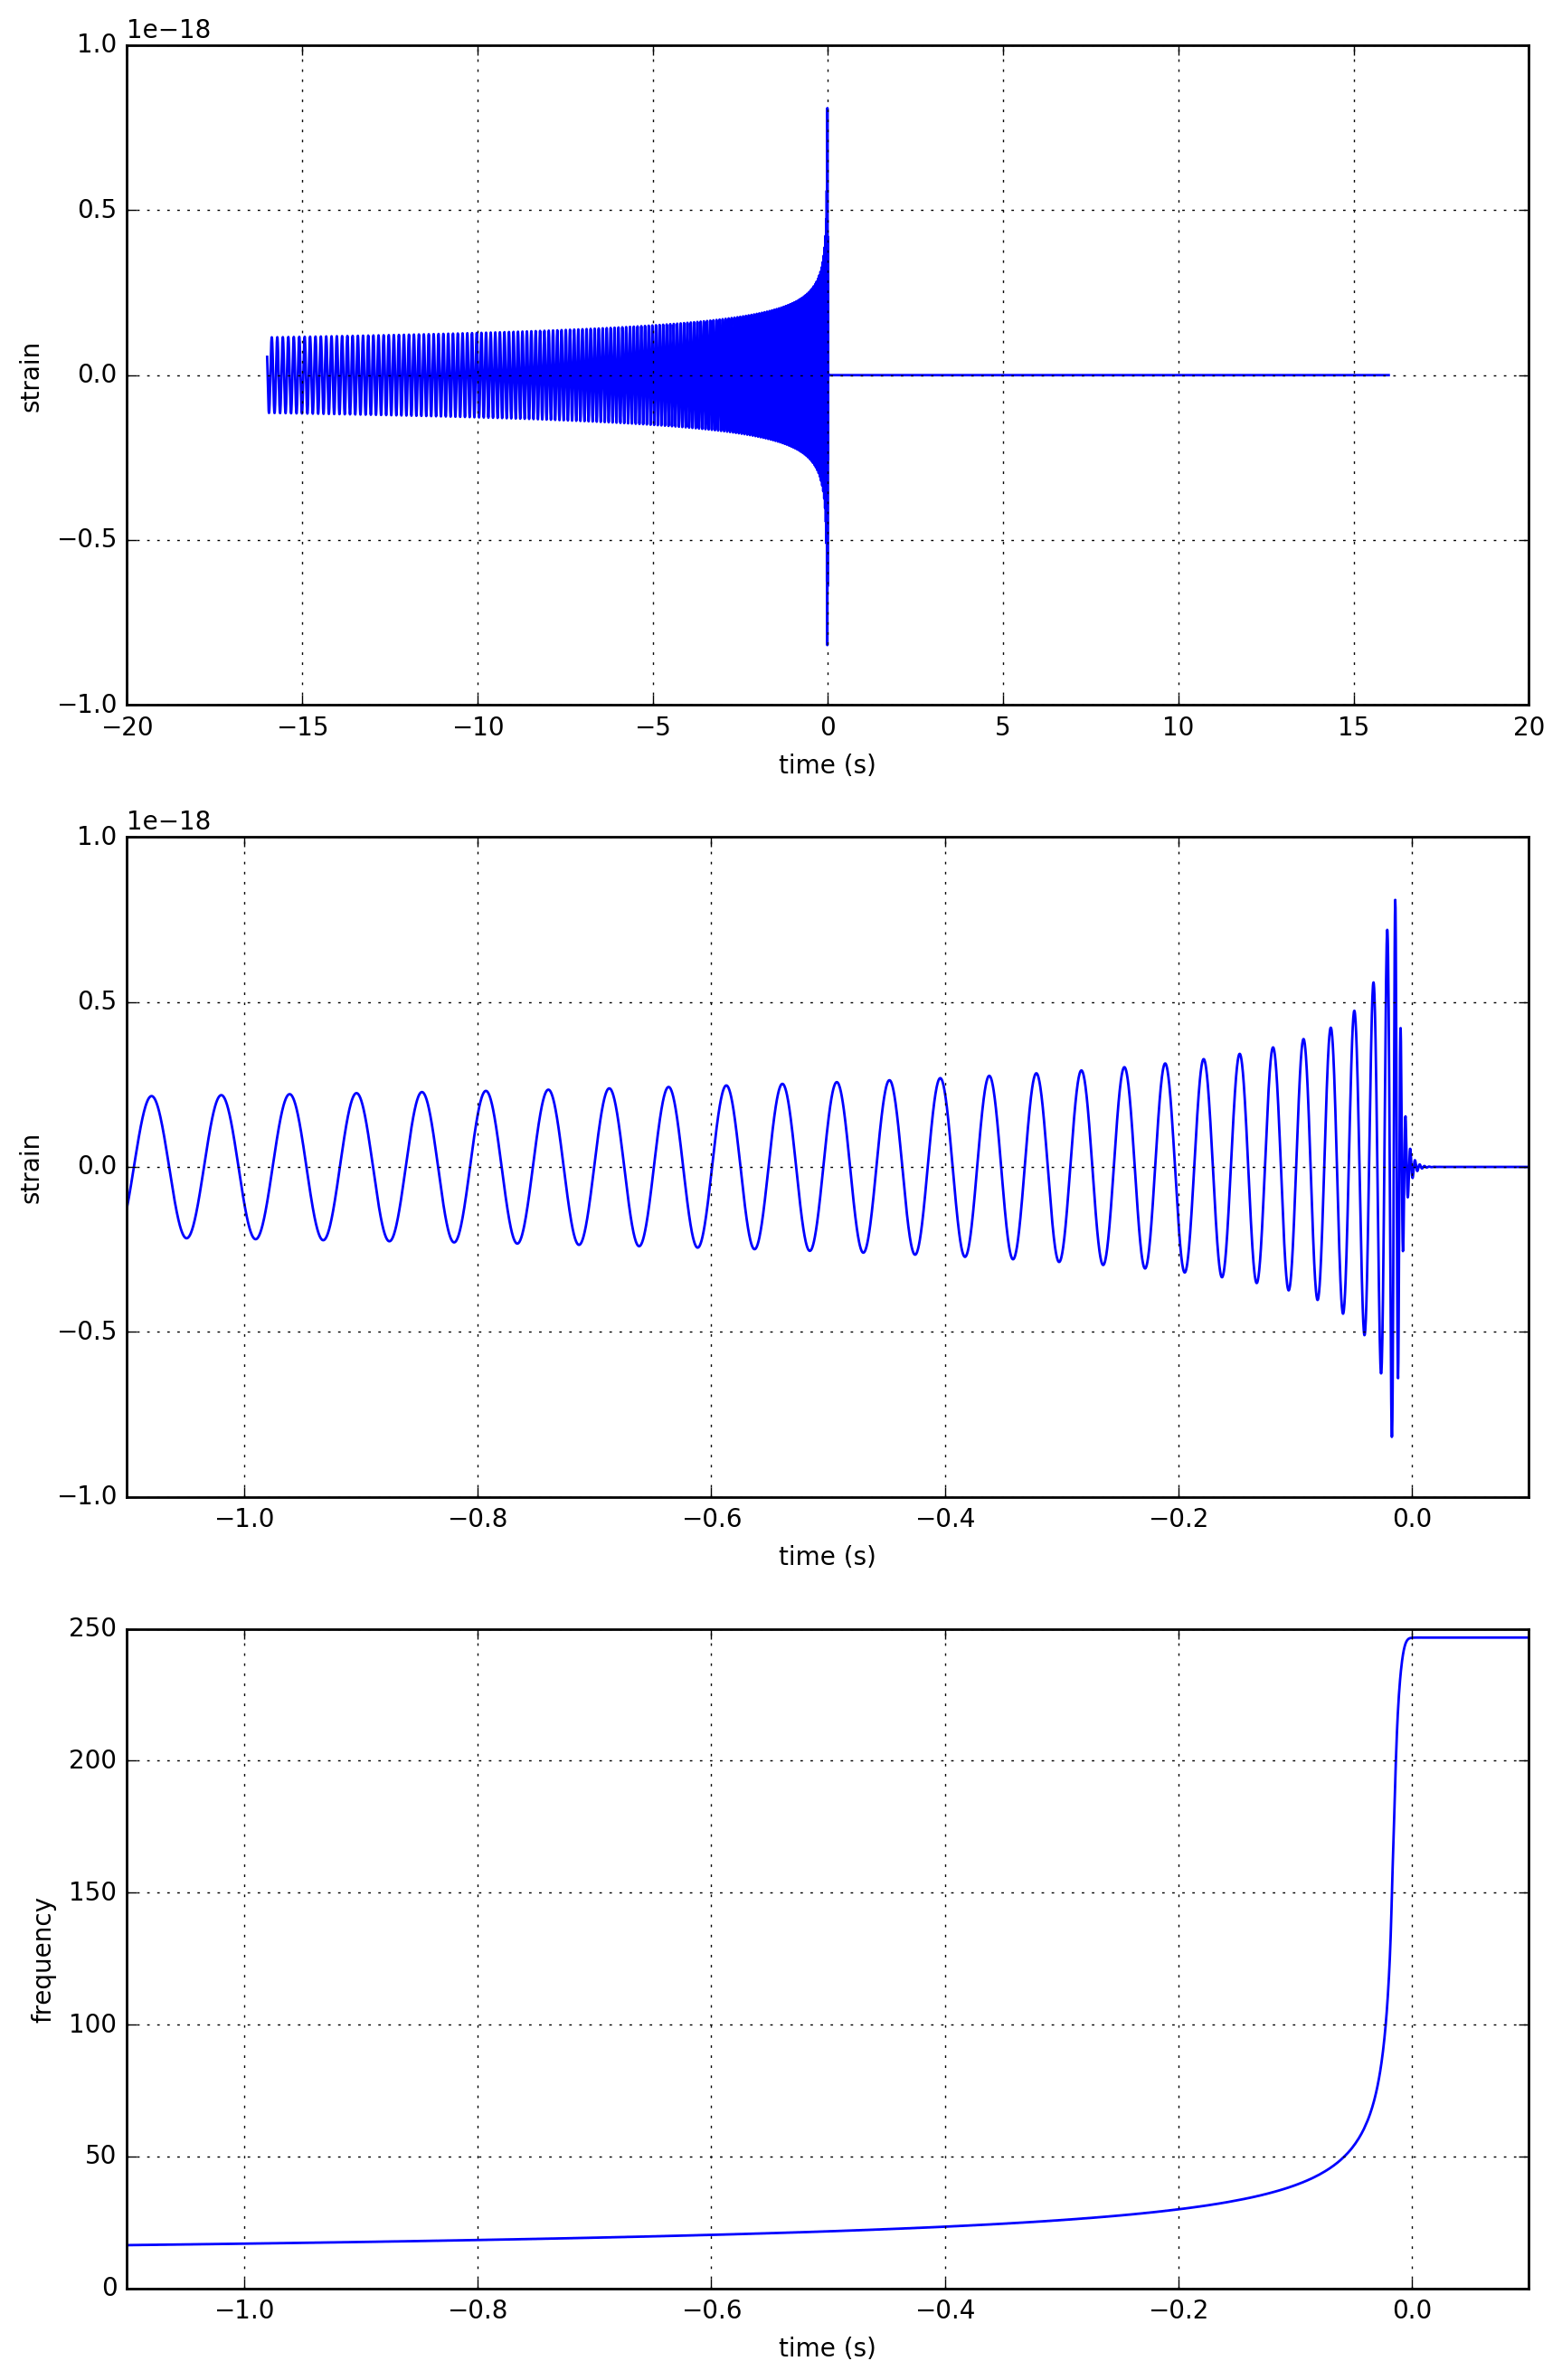

In [11]:
# calculate template frequency evolution
tphase = np.unwrap(np.angle(template))
fGW = np.gradient(tphase)*fs/(2.*np.pi)
# fix discontinuities at the very end:
# iffix = np.where(np.abs(np.gradient(fGW)) > 100.)[0]
iffix = np.where(np.abs(template) < np.abs(template).max()*0.001)[0]
fGW[iffix] = fGW[iffix[0]-1]
fGW[np.where(fGW < 1.)] = fGW[iffix[0]-1]

plt.figure(figsize=(10,16))
plt.subplot(3,1,1)
plt.plot(ttime, np.real(template))
plt.grid()
plt.xlabel('time (s)')
plt.ylabel('strain')
    
plt.subplot(3,1,2)
plt.plot(ttime, np.real(template))
plt.xlim([-1.1, 0.1])
plt.grid()
plt.xlabel('time (s)')
plt.ylabel('strain')
    
plt.subplot(3,1,3)
plt.plot(ttime, fGW)
plt.xlim([-1.1, 0.1])
plt.grid()
plt.xlabel('time (s)')
plt.ylabel('frequency')

# Process data to look for gravitational wave

Ok, here's where we actually search our data for signals that look like our template.

We first *instantiate* our matched filter object using the MatchedFilter class we defined above.  

### instantiate the matched filter

Remember, matched filters need a template, so we provide the template as the input argument when creating the MatchedFilter object.

In [26]:
matched_filter = MatchedFilter(template, fs)

### "filter" the data to look for the template signal

The result of matched filter is an "SNR time series", which is tells us how much the data looks like the filter at each moment in time.  If the SNR time series is small (close to one) the data looks like noise and not the template.  If the SNR time series is large, the data looks a lot like the template.  (The SNR timeseries is complex, but we can just look at the absolute value to see the SNR value.)

The matched filtering also returns a "sigma" array that we'll use to post process the data for plotting.

In [27]:
SNR_complex, sigma = matched_filter.filter_data(strain, fs)

find the time of the maximum SNR, which should correspond to the time of the event

In [14]:
SNR = abs(SNR_complex)
indmax = np.argmax(SNR)
timemax = time[indmax]
SNRmax = SNR[indmax]
print("maximum SNR: {}".format(SNRmax))
print("event time: {}".format(timemax))
tevent = timemax

maximum SNR: 18.601316805900552
event time: 1126259462.4414062


### Gravitational wave event detected!

### Plot the data at the time of the event

Now let's plot the data around the time of the event.  We will also plot the template at the time of the event, and show how well they match.

We have to use some information from the matched filter output to shift and scale the template so that it matches where exactly the signal is in the data.

We start by creating some filters that we will be using.

In [15]:
whitening_filter = WhiteningFilter(strain, fs)

In [16]:
bandpass_filter = BandPassFilter((43.0, 300.0))

In [17]:
# we can calculate the "effective distance" from the max SNR (see FINDCHIRP paper for definition)
# d_eff = (8. / SNRmax)*D_thresh
d_eff = sigma / SNRmax

# extract time offset and phase at peak
phase = np.angle(SNR_complex[indmax])
peaksample = int(strain.size / 2)
offset = (indmax-peaksample)

In [18]:
# whiten the strain data
strain_whiten = whitening_filter.filter_data(strain, fs)
strain_whitenbp = bandpass_filter.filter_data(strain_whiten, fs)
#strain_whitenbp = bandpass_filter.filter_data(strain, fs)

# whiten the template
template_p_whiten = whitening_filter.filter_data(np.real(template), fs)
template_c_whiten = whitening_filter.filter_data(np.imag(template), fs)
template_p_whitenbp = bandpass_filter.filter_data(template_p_whiten, fs)
template_c_whitenbp = bandpass_filter.filter_data(template_c_whiten, fs)
#template_p_whitenbp = bandpass_filter.filter_data(template_p, fs)
#template_c_whitenbp = bandpass_filter.filter_data(template_c, fs)
# apply time offset, phase, and d_eff to the whitened template
template_whitened = (template_p_whitenbp + template_c_whitenbp*1.j) 
template_phaseshifted = np.real(template_whitened*np.exp(1j*phase))
template_match = np.roll(template_phaseshifted, offset) / d_eff  

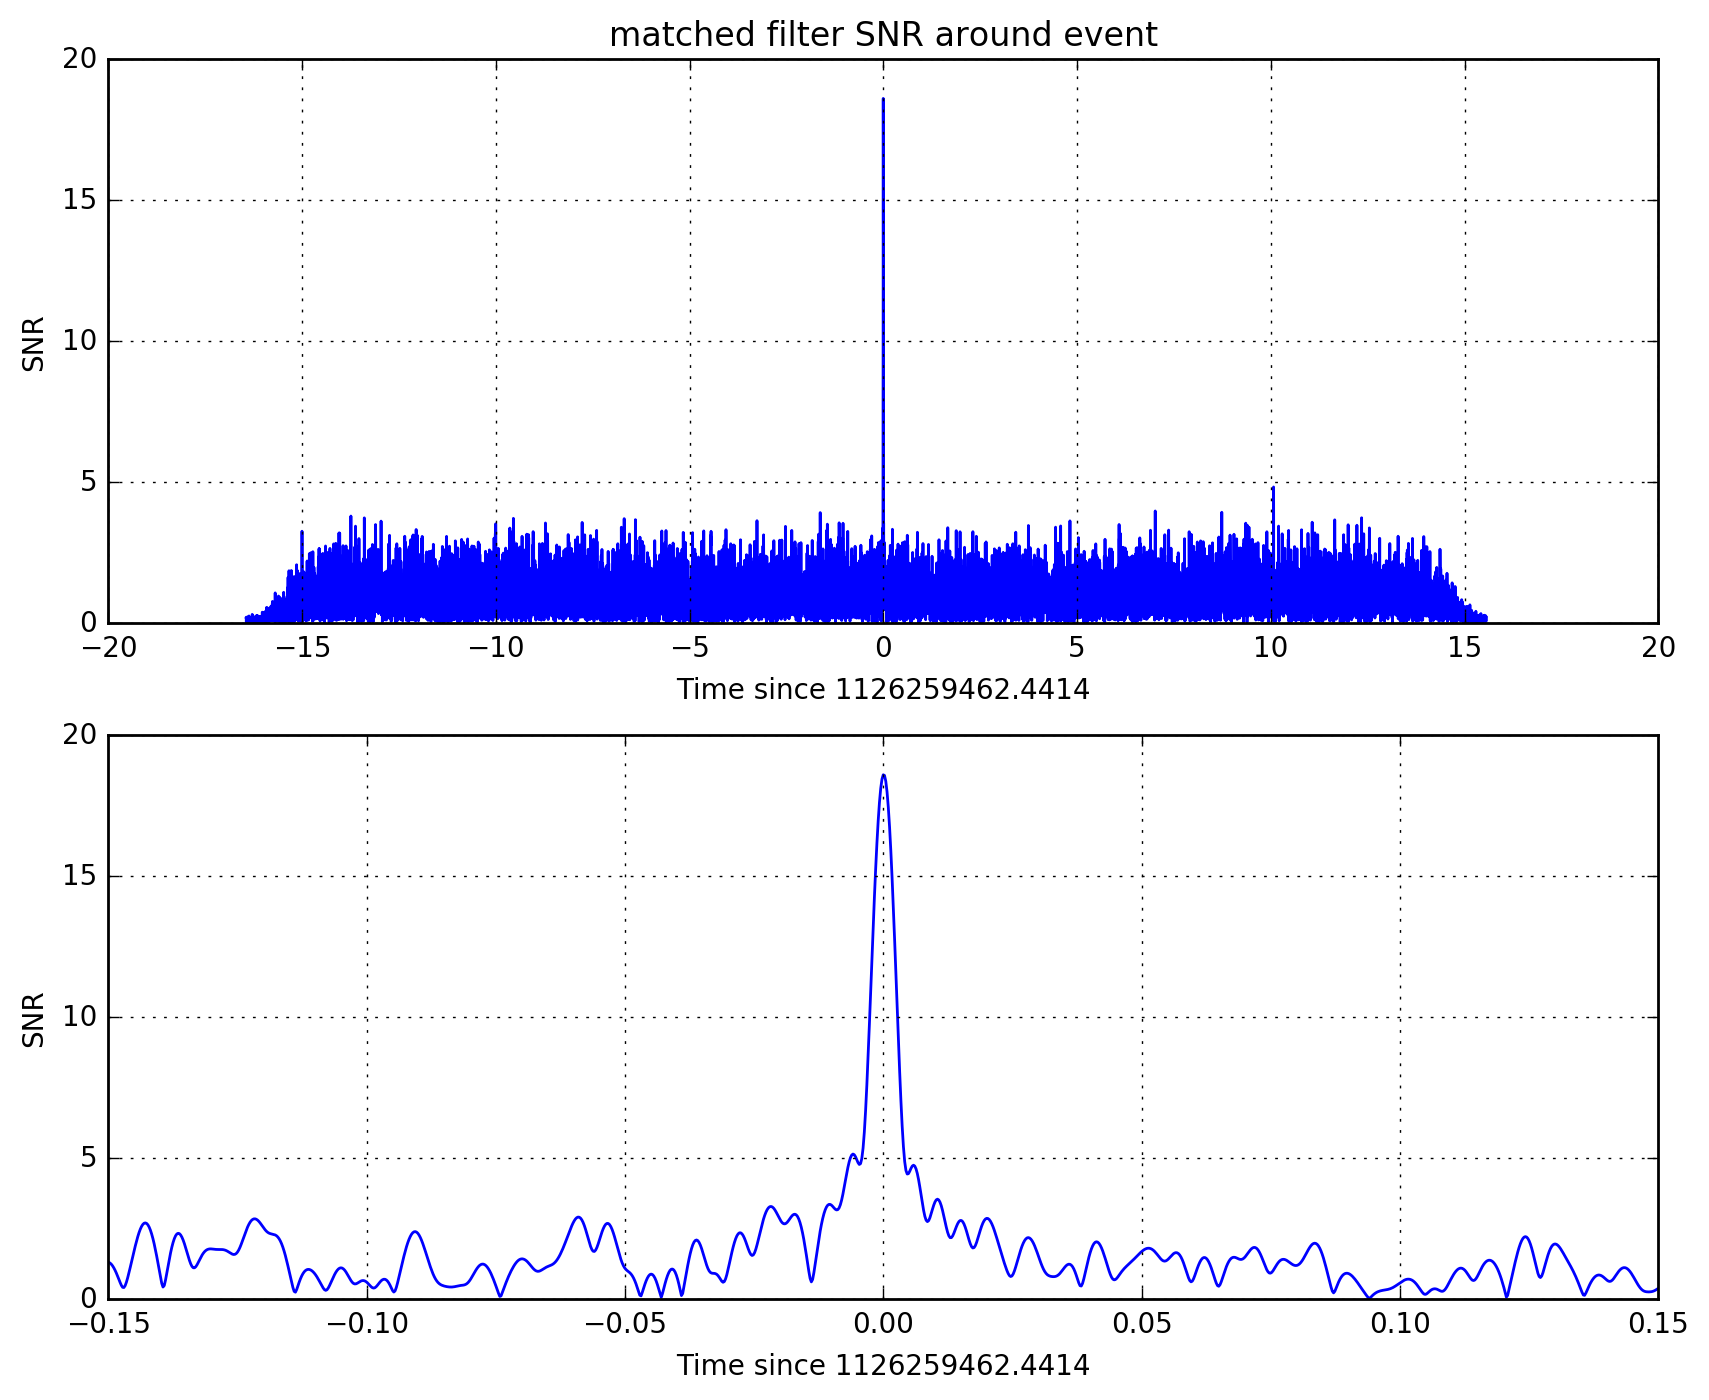

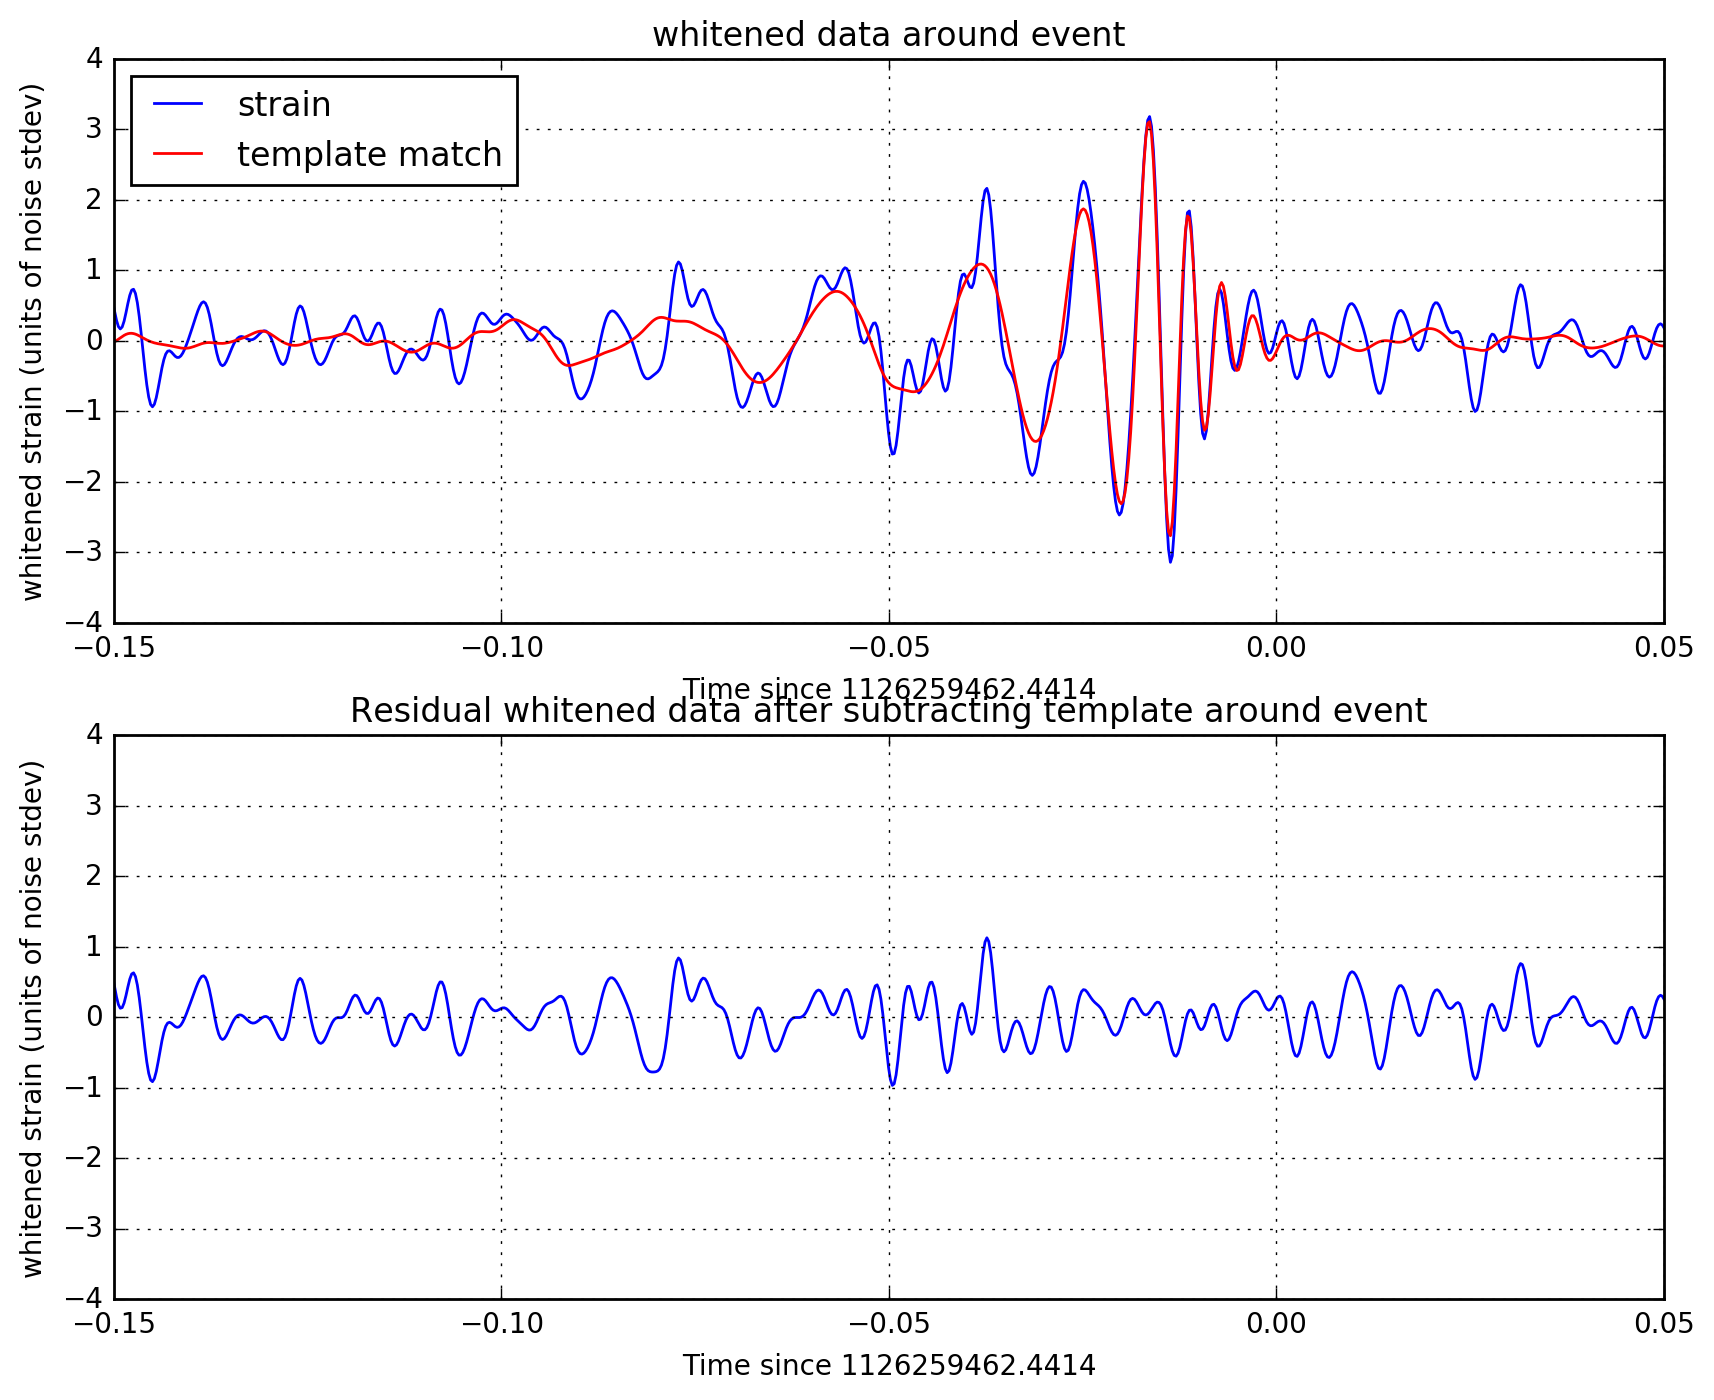

In [19]:
plt.figure(figsize=(10,8))
plt.subplot(2,1,1)
plt.plot(time-tevent, SNR)
plt.grid('on')
plt.ylabel('SNR')
plt.xlabel('Time since {0:.4f}'.format(tevent))
plt.title('matched filter SNR around event')

# zoom in
plt.subplot(2,1,2)
plt.plot(time-tevent, SNR)
plt.grid('on')
plt.ylabel('SNR')
plt.xlim([-0.15,0.15])
plt.grid('on')
plt.xlabel('Time since {0:.4f}'.format(tevent))

plt.figure(figsize=(10,8))
plt.subplot(2,1,1)
plt.plot(time-tevent, strain_whitenbp, 'b', label='strain')
plt.plot(time-tevent, template_match, 'r', label='template match')
plt.ylim([-4, 4])
#plt.ylim([-2e-21, 2e-21])
plt.xlim([-0.15, 0.05])
plt.grid('on')
plt.xlabel('Time since {0:.4f}'.format(tevent))
plt.ylabel('whitened strain (units of noise stdev)')
plt.legend(loc='upper left')
plt.title('whitened data around event')

plt.subplot(2,1,2)
plt.plot(time-tevent, strain_whitenbp-template_match)
plt.ylim([-4, 4])
#plt.ylim([-2e-21, 2e-21])
plt.xlim([-0.15, 0.05])
plt.grid('on')
plt.xlabel('Time since {0:.4f}'.format(tevent))
plt.ylabel('whitened strain (units of noise stdev)')
plt.title('Residual whitened data after subtracting template around event')

Note that the "residual" data after the template was subtracted just looks like noise!  That's a good indicator that the signal in the data looked very much like our template.

And viola!  We can see in the plot of the SNR time series that we have a strong match to the template at the predicted time of the event (`tevent` above).

Now you can try to replicate this techniques with other templates...

# Extra fun stuff

## plot the amplitude spectral density (ASD) of the data

Plotting data in the Fourier domain gives an idea of the frequency content of the data. A way to visualize the frequency content of the data is to plot the amplitude spectral density, ASD.

The ASDs are the square root of the power spectral densities (PSDs), which are averages of the square of the fast fourier transforms (FFTs) of the data.

They are an estimate of the "strain-equivalent noise" of the detectors versus frequency,
which limit the ability of the detectors to identify GW signals.

They are in units of strain/rt(Hz).
So, if you want to know the root-mean-square (rms) strain noise in a frequency band,
integrate (sum) the squares of the ASD over that band, then take the square-root.

There's a signal in these data! 
but for the moment, let's ignore that, and assume it's all noise.

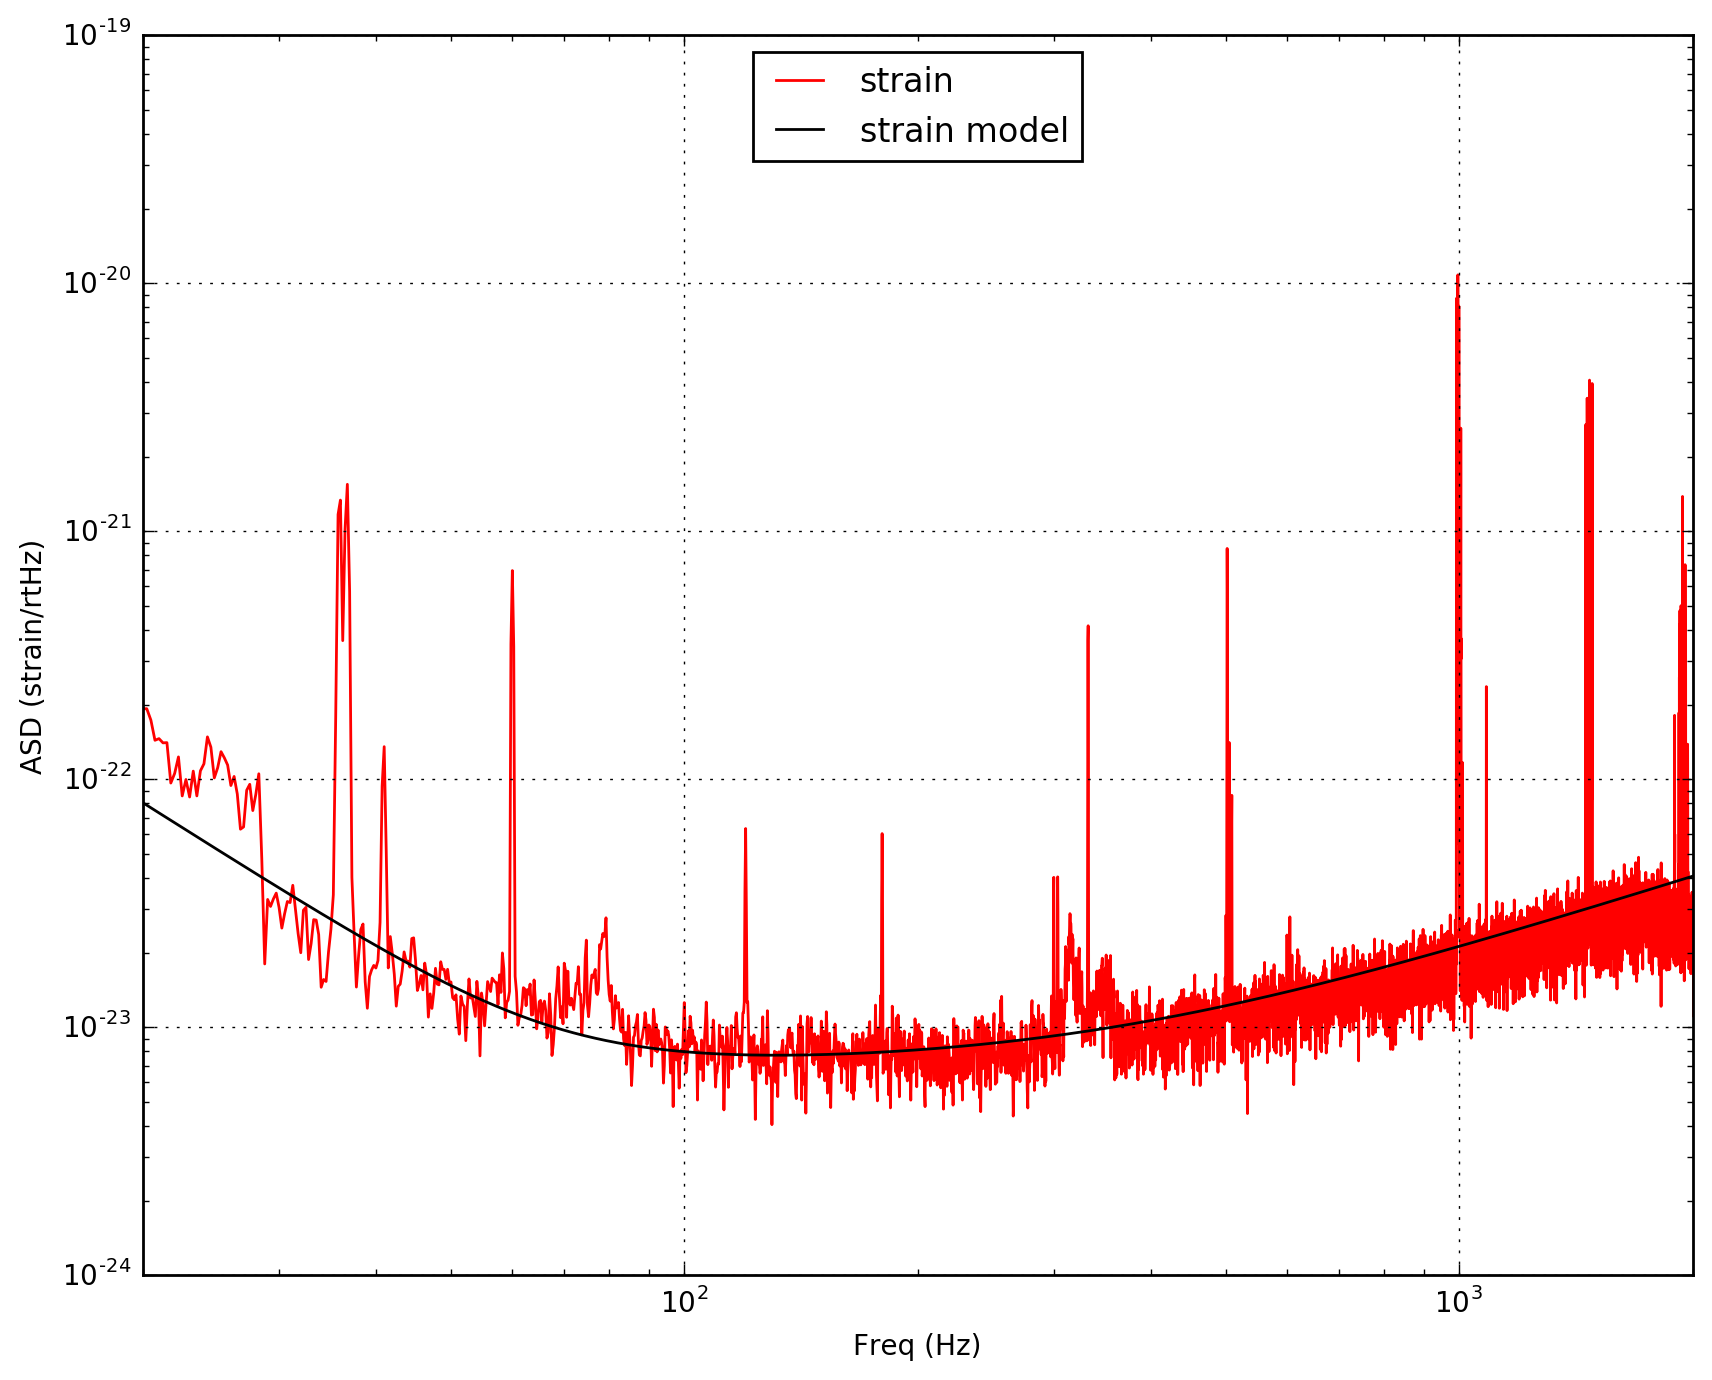

In [20]:
# number of sample for the fast fourier transform:
NFFT = 4*fs
Pxx, freqs = mlab.psd(strain, Fs=fs, NFFT=NFFT)

# Here is an approximate, smoothed PSD for H1 during O1, with no lines. We'll use it later.    
Pxx_smooth = (1.e-22*(18./(0.1+freqs))**2)**2+0.7e-23**2+((freqs/2000.)*4.e-23)**2
psd_smooth = interp1d(freqs, Pxx_smooth)

# plot the ASDs, with the template overlaid:
f_min = 20.
f_max = 2000. 
plt.figure(figsize=(10,8))
plt.loglog(freqs, np.sqrt(Pxx),'r',label='strain')
plt.loglog(freqs, np.sqrt(Pxx_smooth),'k',label='strain model')
plt.axis([f_min, f_max, 1e-24, 1e-19])
plt.grid('on')
plt.ylabel('ASD (strain/rtHz)')
plt.xlabel('Freq (Hz)')
plt.legend(loc='upper center')

## Plot Spectrograms of data

A spectrogram is like a amplitude spectral density plot, except that it plots the amplitude as a color, and shows how the ASD evolves over time.  In this case the frequency is on the y axis.

[-5, 5, 0, 2000]

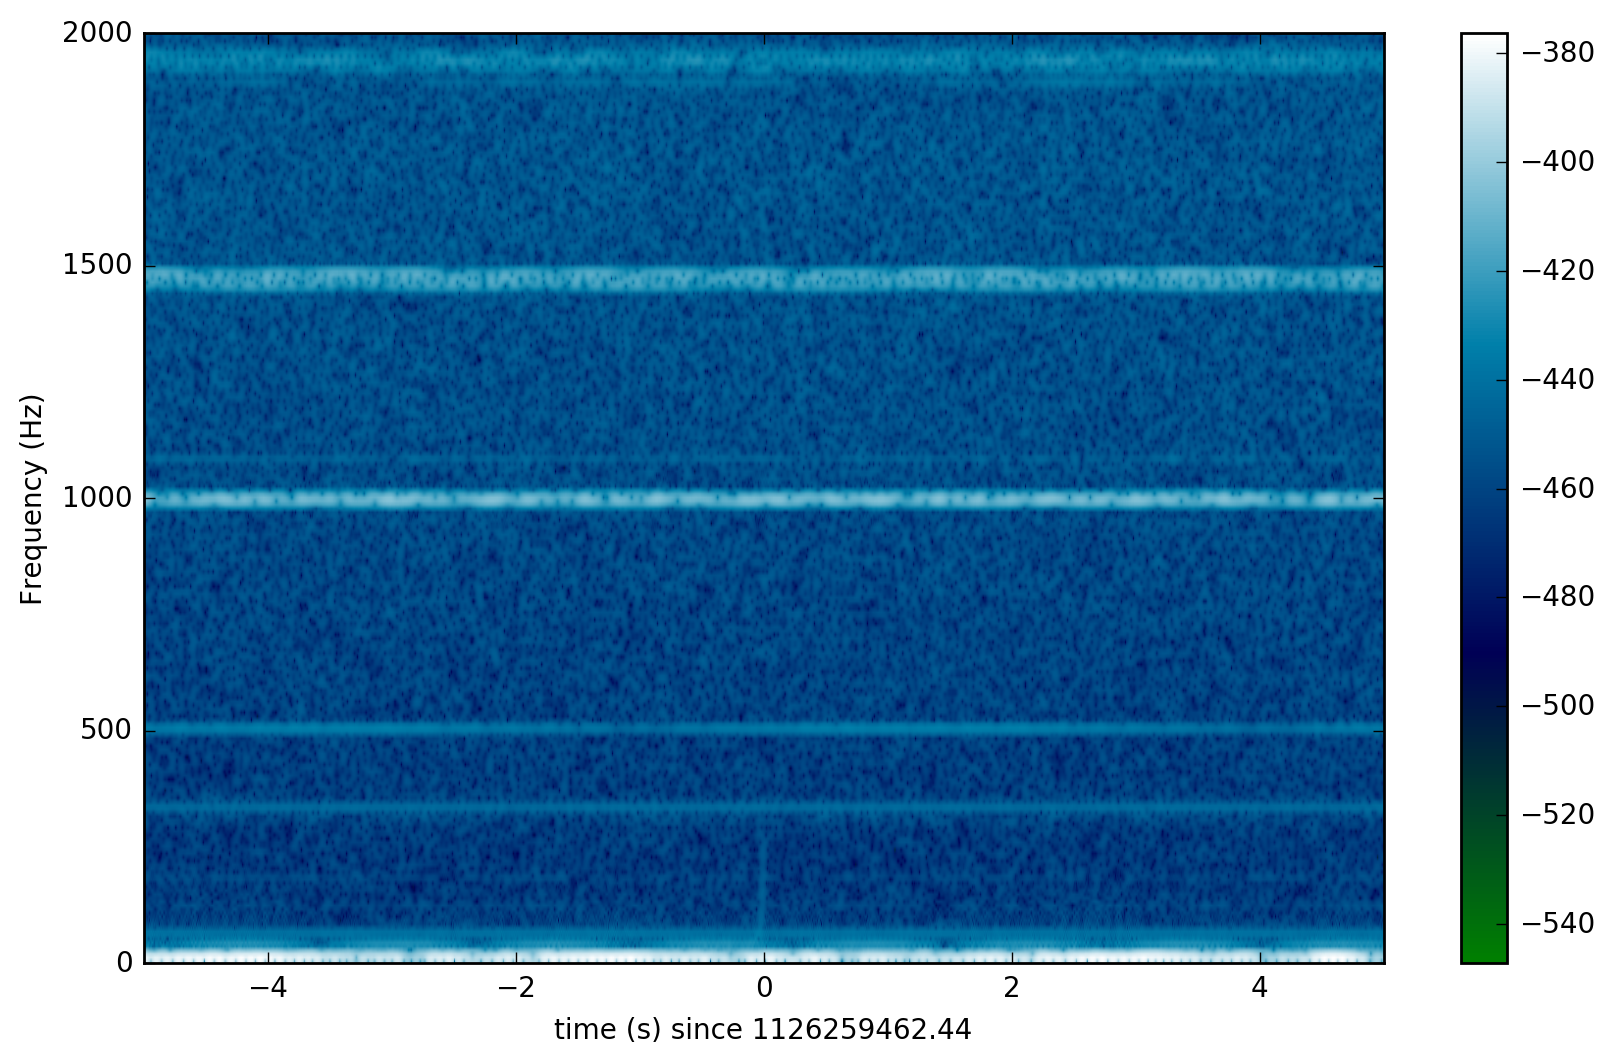

In [21]:
# index into the strain time series for this time interval:
indxt = np.where((time >= tevent-deltat) & (time < tevent+deltat))

# pick a shorter FTT time interval, like 1/8 of a second:
NFFT = int(fs/8)
# and with a lot of overlap, to resolve short-time features:
NOVL = int(NFFT*15./16)
# and choose a window that minimizes "spectral leakage" 
# (https://en.wikipedia.org/wiki/Spectral_leakage)
window = np.blackman(NFFT)

# the right colormap is all-important! See:
# http://matplotlib.org/examples/color/colormaps_reference.html
# viridis seems to be the best for our purposes, but it's new; if you don't have it, you can settle for ocean.
#spec_cmap='viridis'
spec_cmap='ocean'

# Plot the spectrogram:
plt.figure(figsize=(10,6))
spec, freqs, bins, im = plt.specgram(strain[indxt], NFFT=NFFT, Fs=fs, window=window, 
                                     noverlap=NOVL, cmap=spec_cmap, xextent=[-deltat,deltat])
plt.xlabel('time (s) since '+str(tevent))
plt.ylabel('Frequency (Hz)')
plt.colorbar()
plt.axis([-deltat, deltat, 0, 2000])

In the above spectrograms, you may see lots of excess power below ~20 Hz, as well as strong spectral lines at 500, 1000, 1500 Hz (also evident in the ASDs above). The lines at multiples of 500 Hz are the harmonics of the "violin modes" of the fibers holding up the mirrors of the Advanced LIGO interferometers.

Now let's zoom in on where we think the signal is, using the whitened data, in the hope of seeing the chirp...

[-0.5, 0.5, 0, 500]

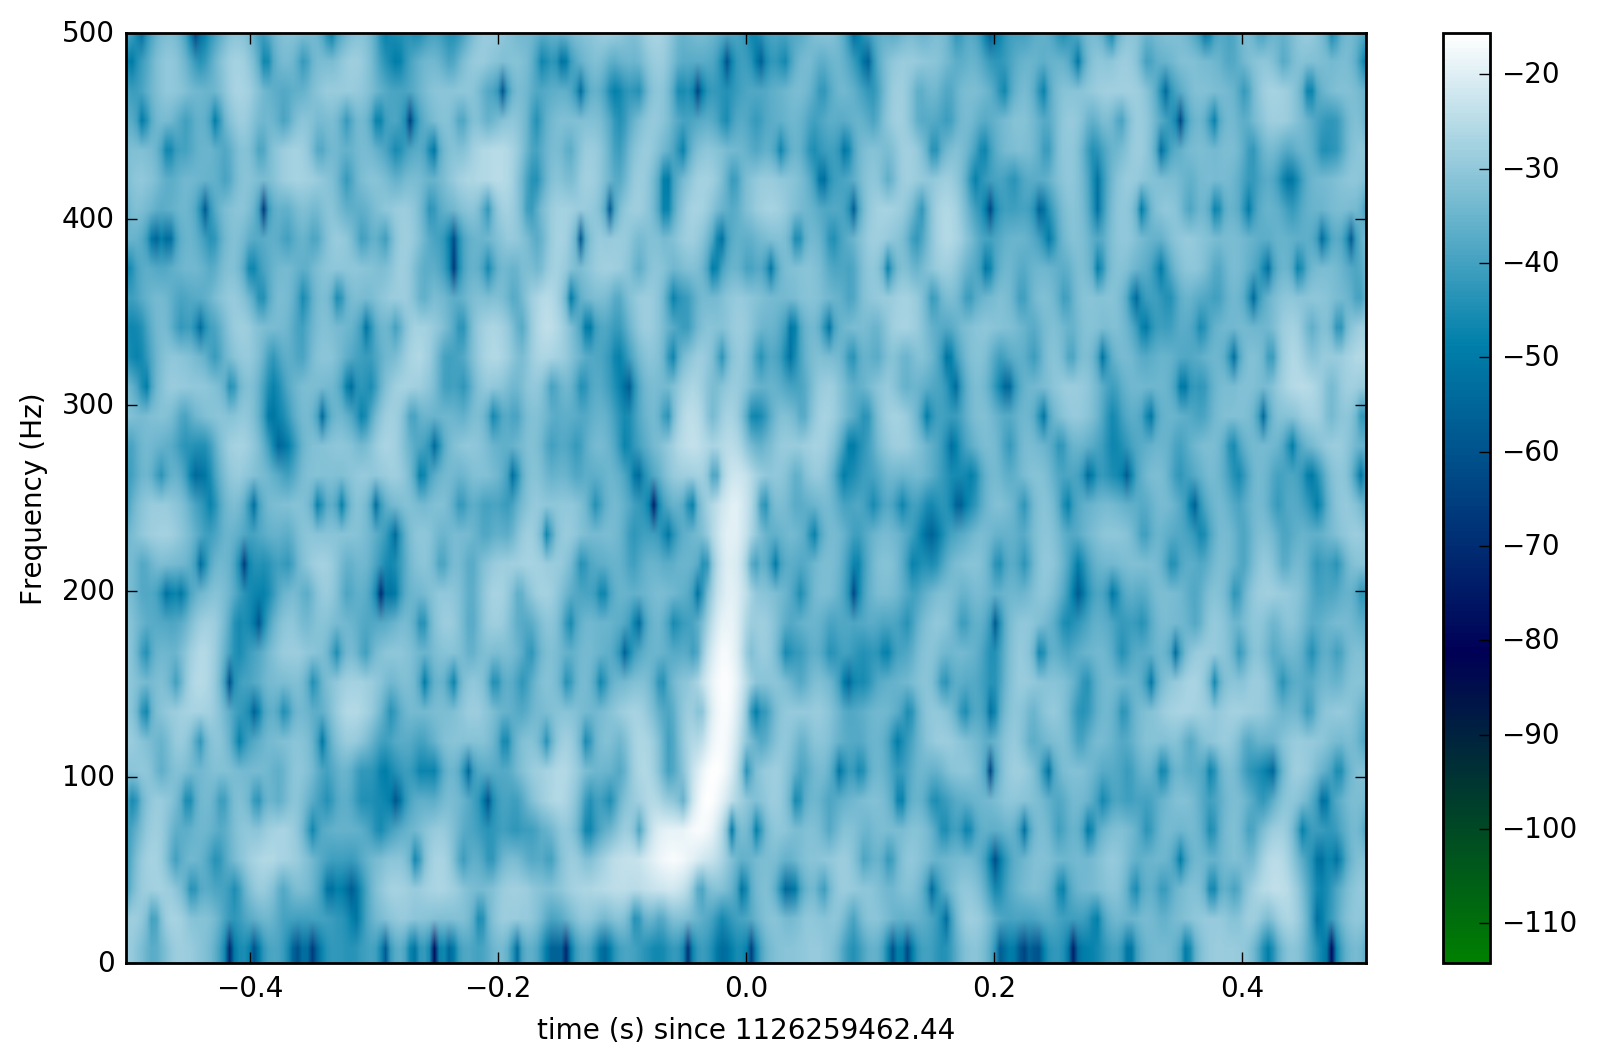

In [22]:
# pick a shorter FTT time interval, like 1/16 of a second:
NFFT = int(fs/16.0)
# and with a lot of overlap, to resolve short-time features:
NOVL = int(NFFT*15/16.0)
# choose a window that minimizes "spectral leakage" 
# (https://en.wikipedia.org/wiki/Spectral_leakage)
window = np.blackman(NFFT)

# Plot the H1 whitened spectrogram around the signal
plt.figure(figsize=(10,6))
spec_H1, freqs, bins, im = plt.specgram(strain_whiten[indxt], NFFT=NFFT, Fs=fs, window=window, 
                                        noverlap=NOVL, cmap=spec_cmap, xextent=[-deltat,deltat])
plt.xlabel('time (s) since '+str(tevent))
plt.ylabel('Frequency (Hz)')
plt.colorbar()
plt.axis([-0.5, 0.5, 0, 500])

Loud (high SNR) signals may be visible in these spectrograms.  Compact object mergers show a characteristic "chirp" as the signal rises in frequency.  If you can't see anything, try
<a href='https://losc.ligo.org/events/GW150914/'>event GW150914</a>, by changing the `eventname` variable in the first cell above.

# Capstone challenges

The directory contains three more chunks of LIGO data that are known to contain gravitational wave signals:

*  H-H1_LOSC_4_V1-1128678884-32.hdf5
*  H-H1_LOSC_4_V1-1135136334-32.hdf5
*  H-H1_LOSC_4_V1-1167559920-32.hdf5

It also contains three different template files:

*  template_A.hdf5
*  template_B.hdf5
*  template_C.hdf5

Here are some challenges using this data:

#### 1. plot the time series of each data chunk

#### 2. plot the ASD of each data chunk on the same plot

#### 3. plot the time series of all three templates

#### 4. calculate the frequency evolution of each template and plot the frequency evolution of all templates on the same plot

*  Make sure each trace is a different color and there is a nice legend.

#### 5. use each template to create thee new matched filters

#### 6. search the three LIGO data chunks for signals with each of the three matched filters:

*  What is the best matching template for each of the three data chunks?
*  What is the time of each event?
*  What is the SNR of each event?

#### 7. plot the best-fit templates against the data, and plot the residual

*  Figure out the best fit phase and offset for each template "match".
*  Whiten and band pass the strain data and the best fit template for each chunk.
*  Plot the whitened/band-passed template and strain data on the same plot.
*  Subtract the best-fit template from the strain and plot the residual.

*  Show that the residual looks like regular noise.

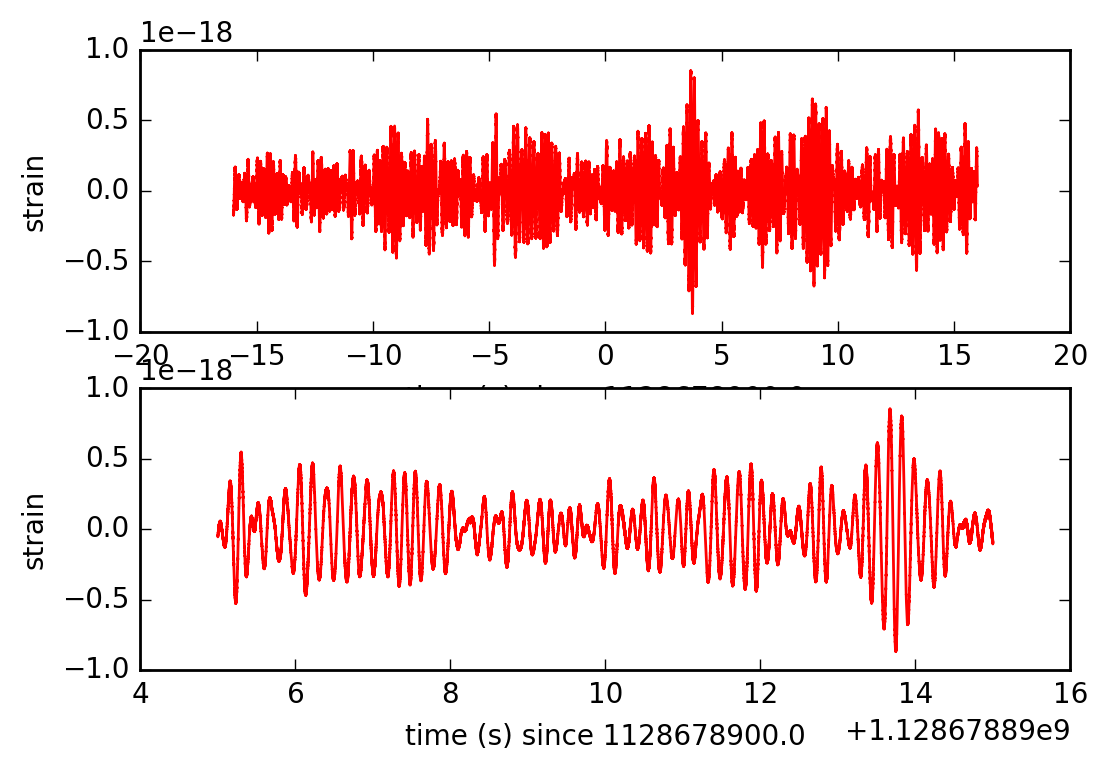

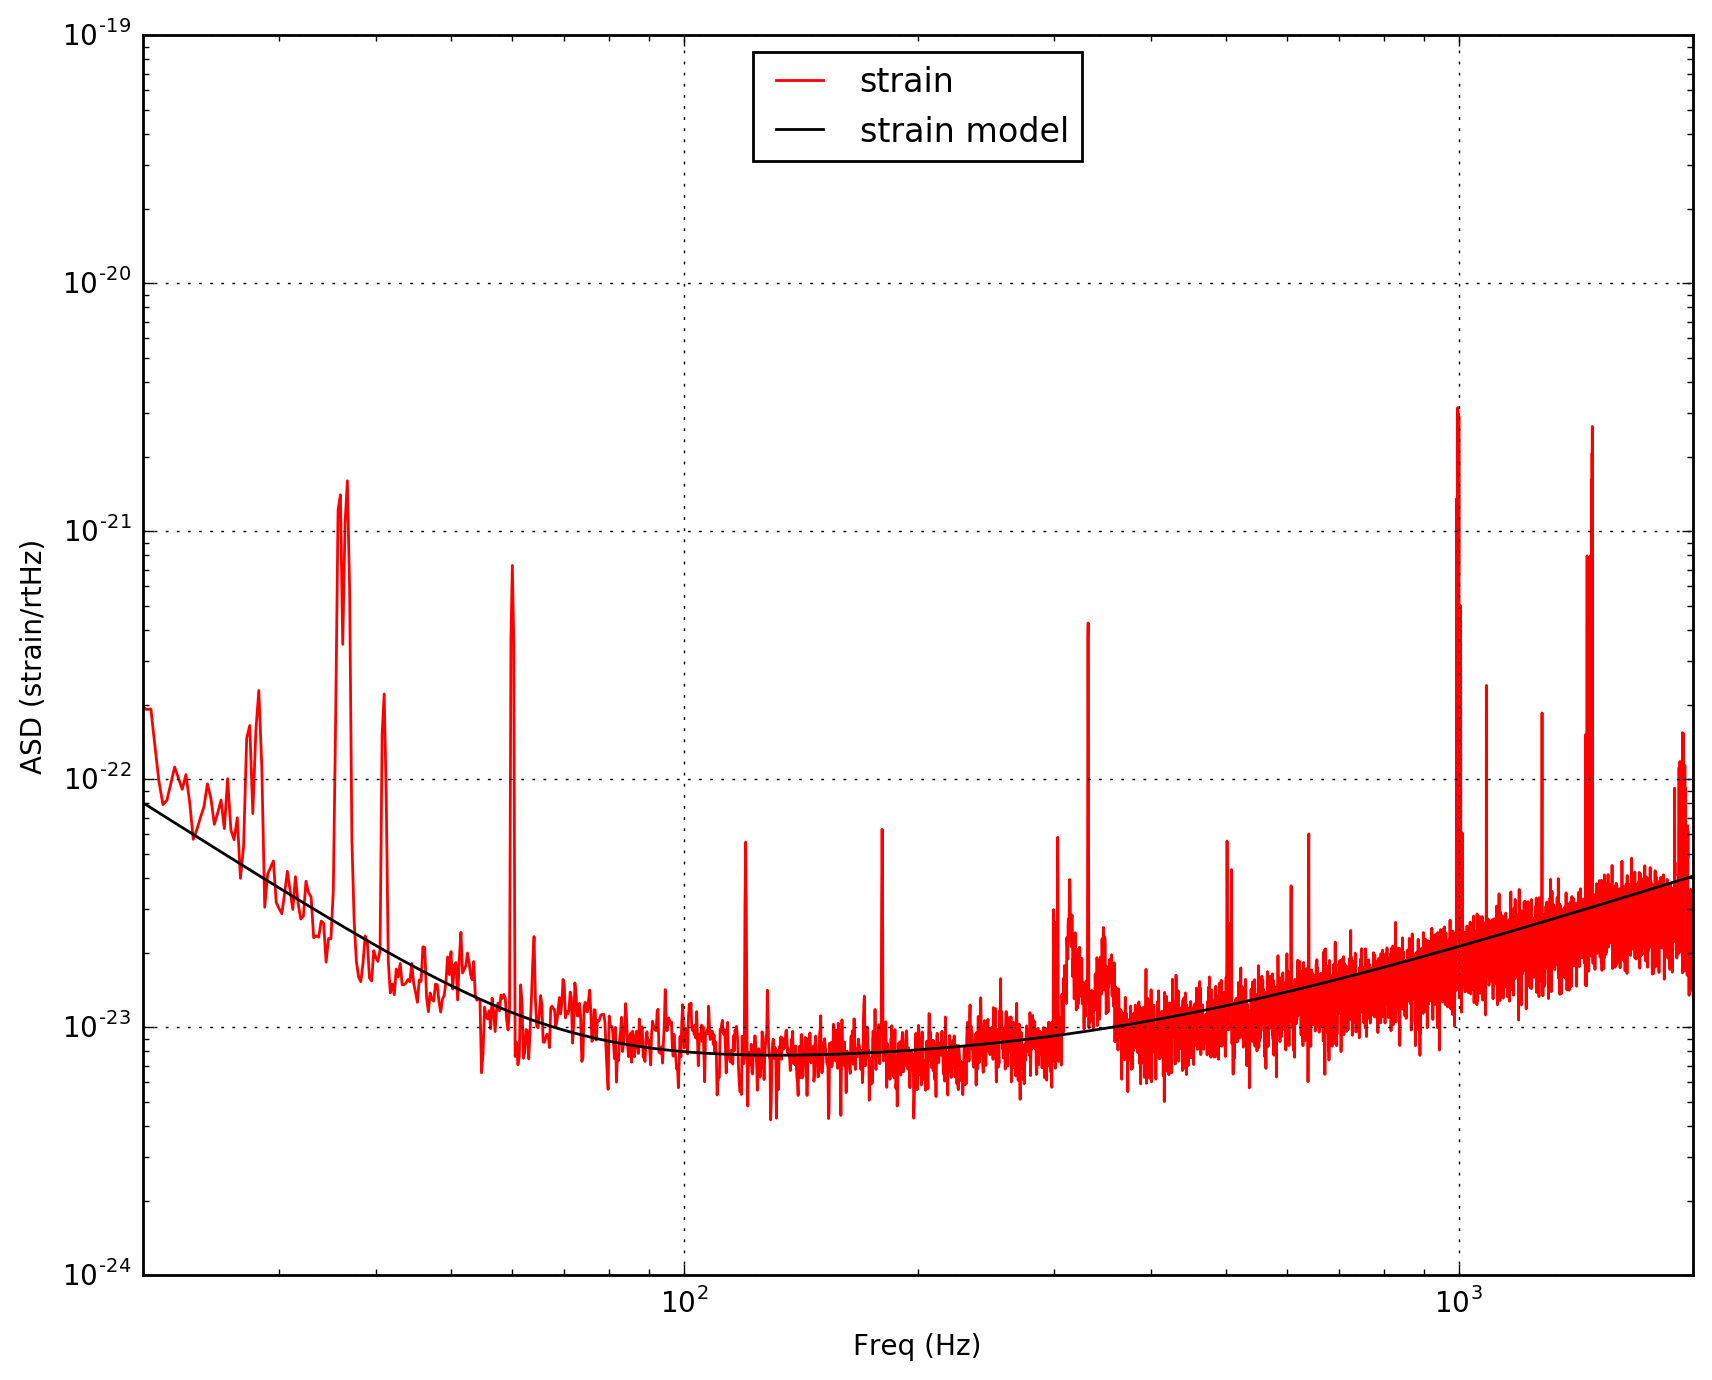

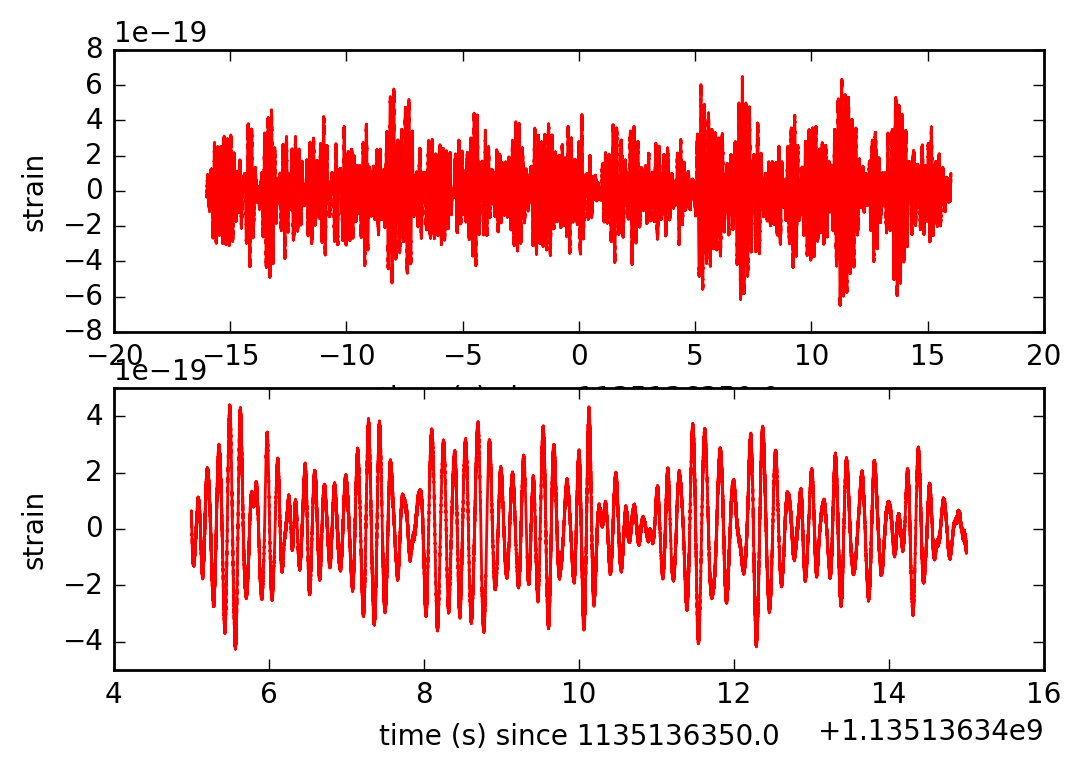

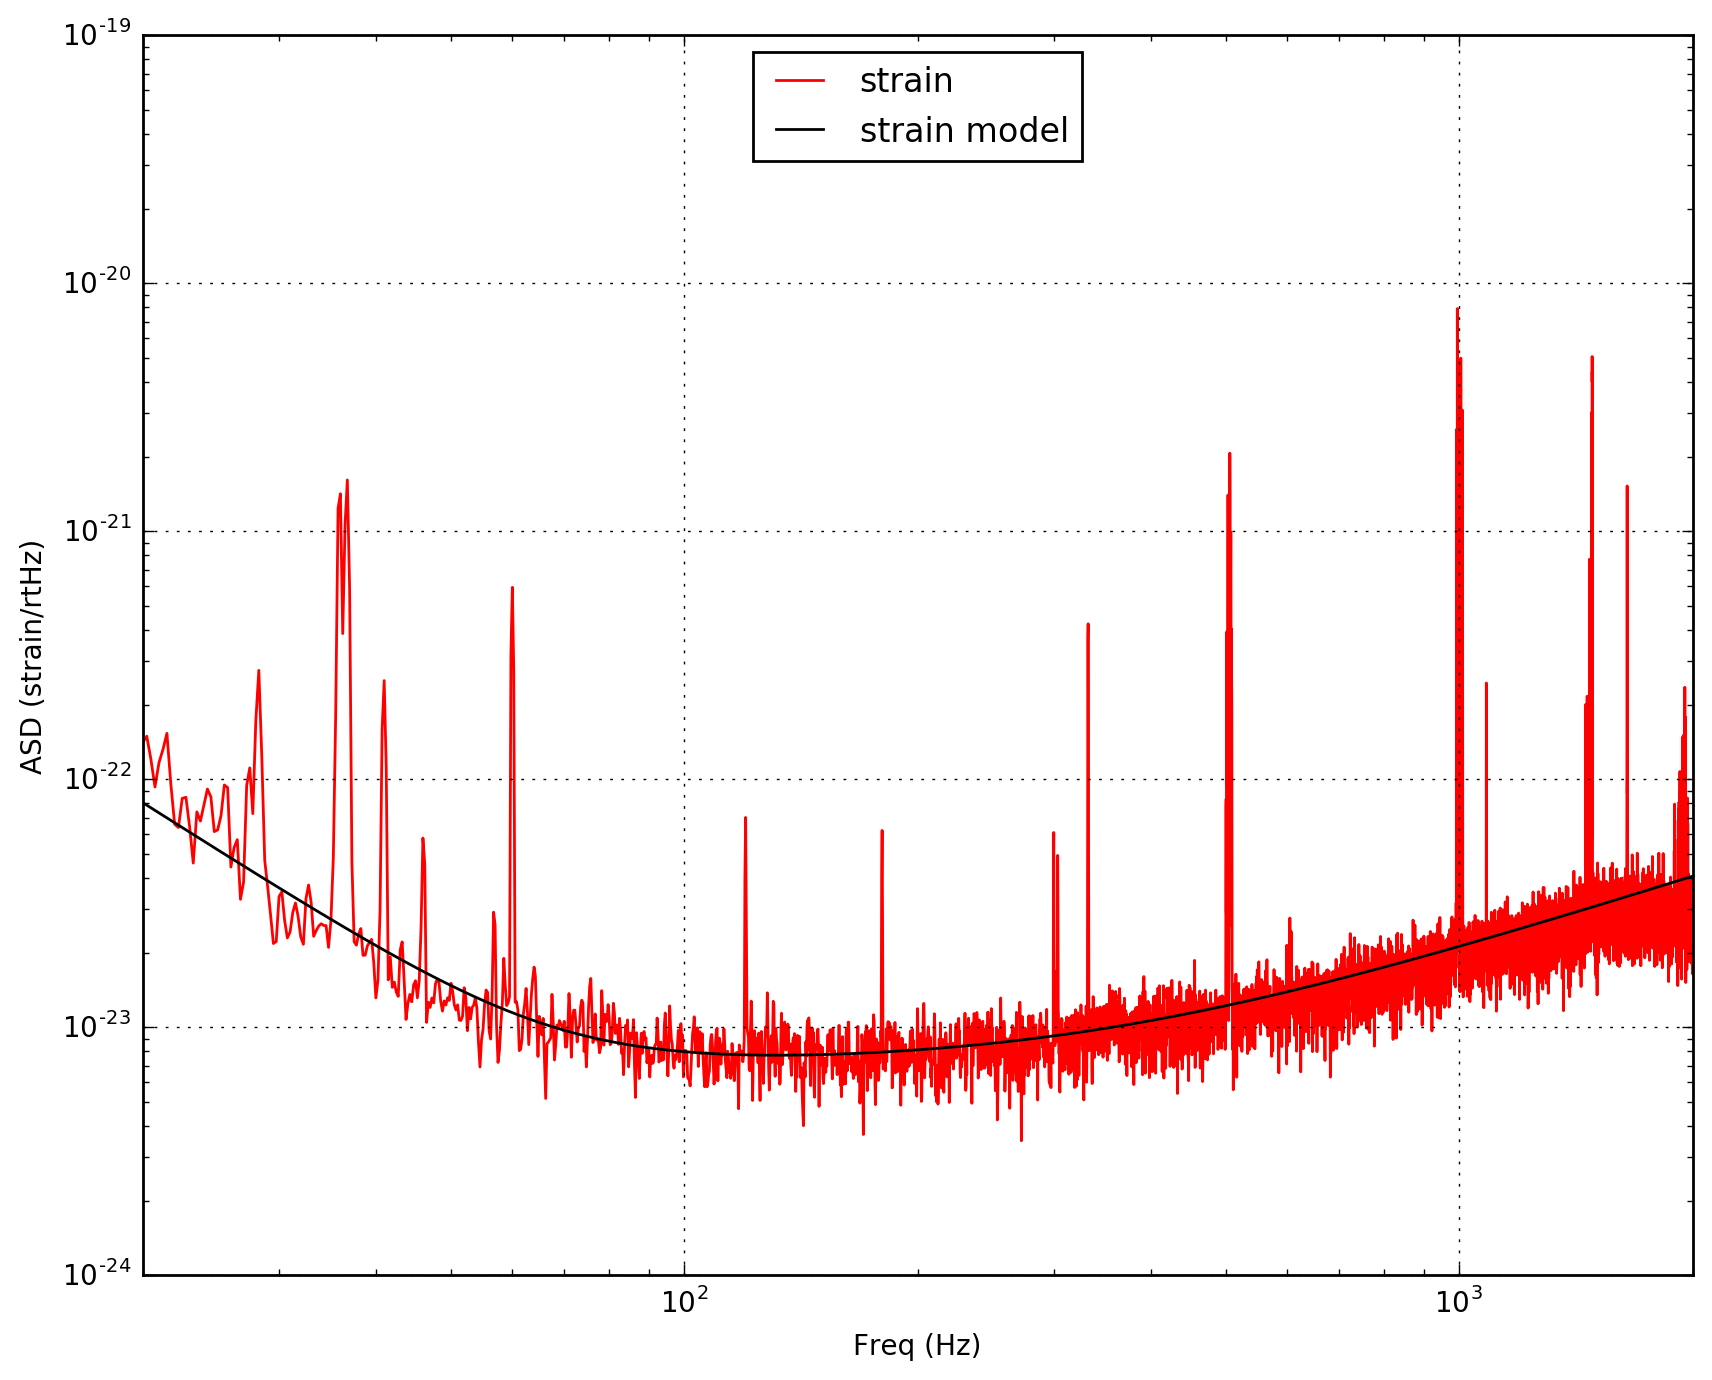

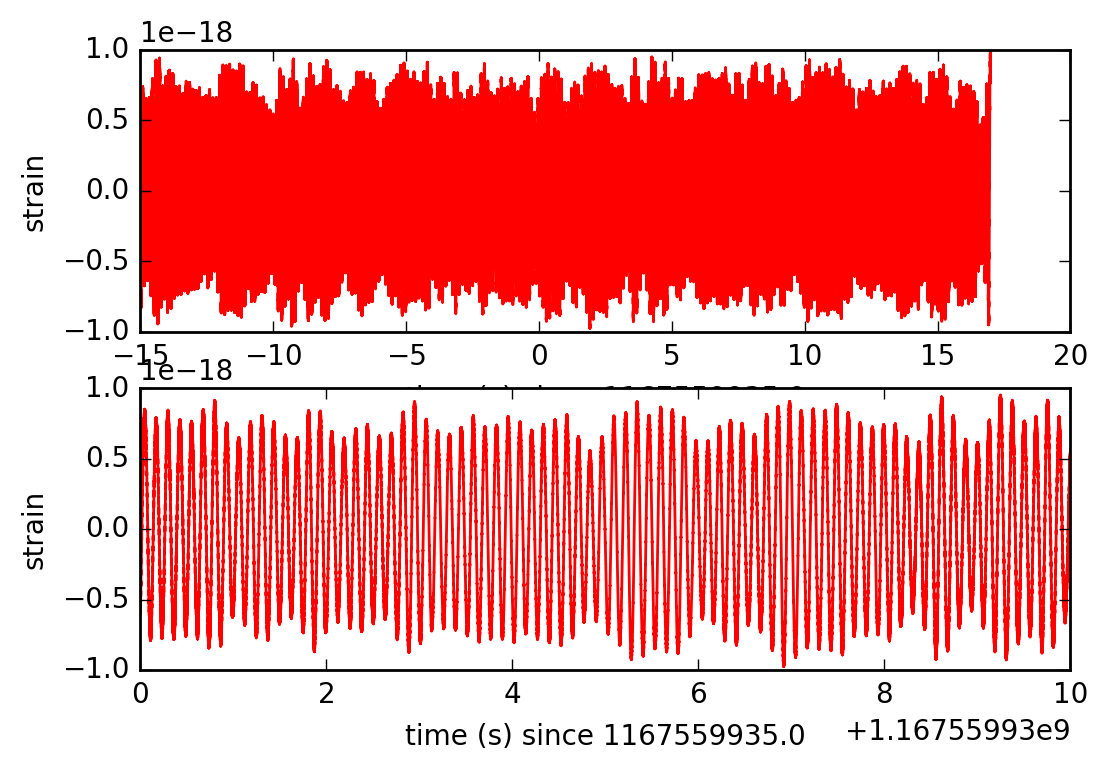

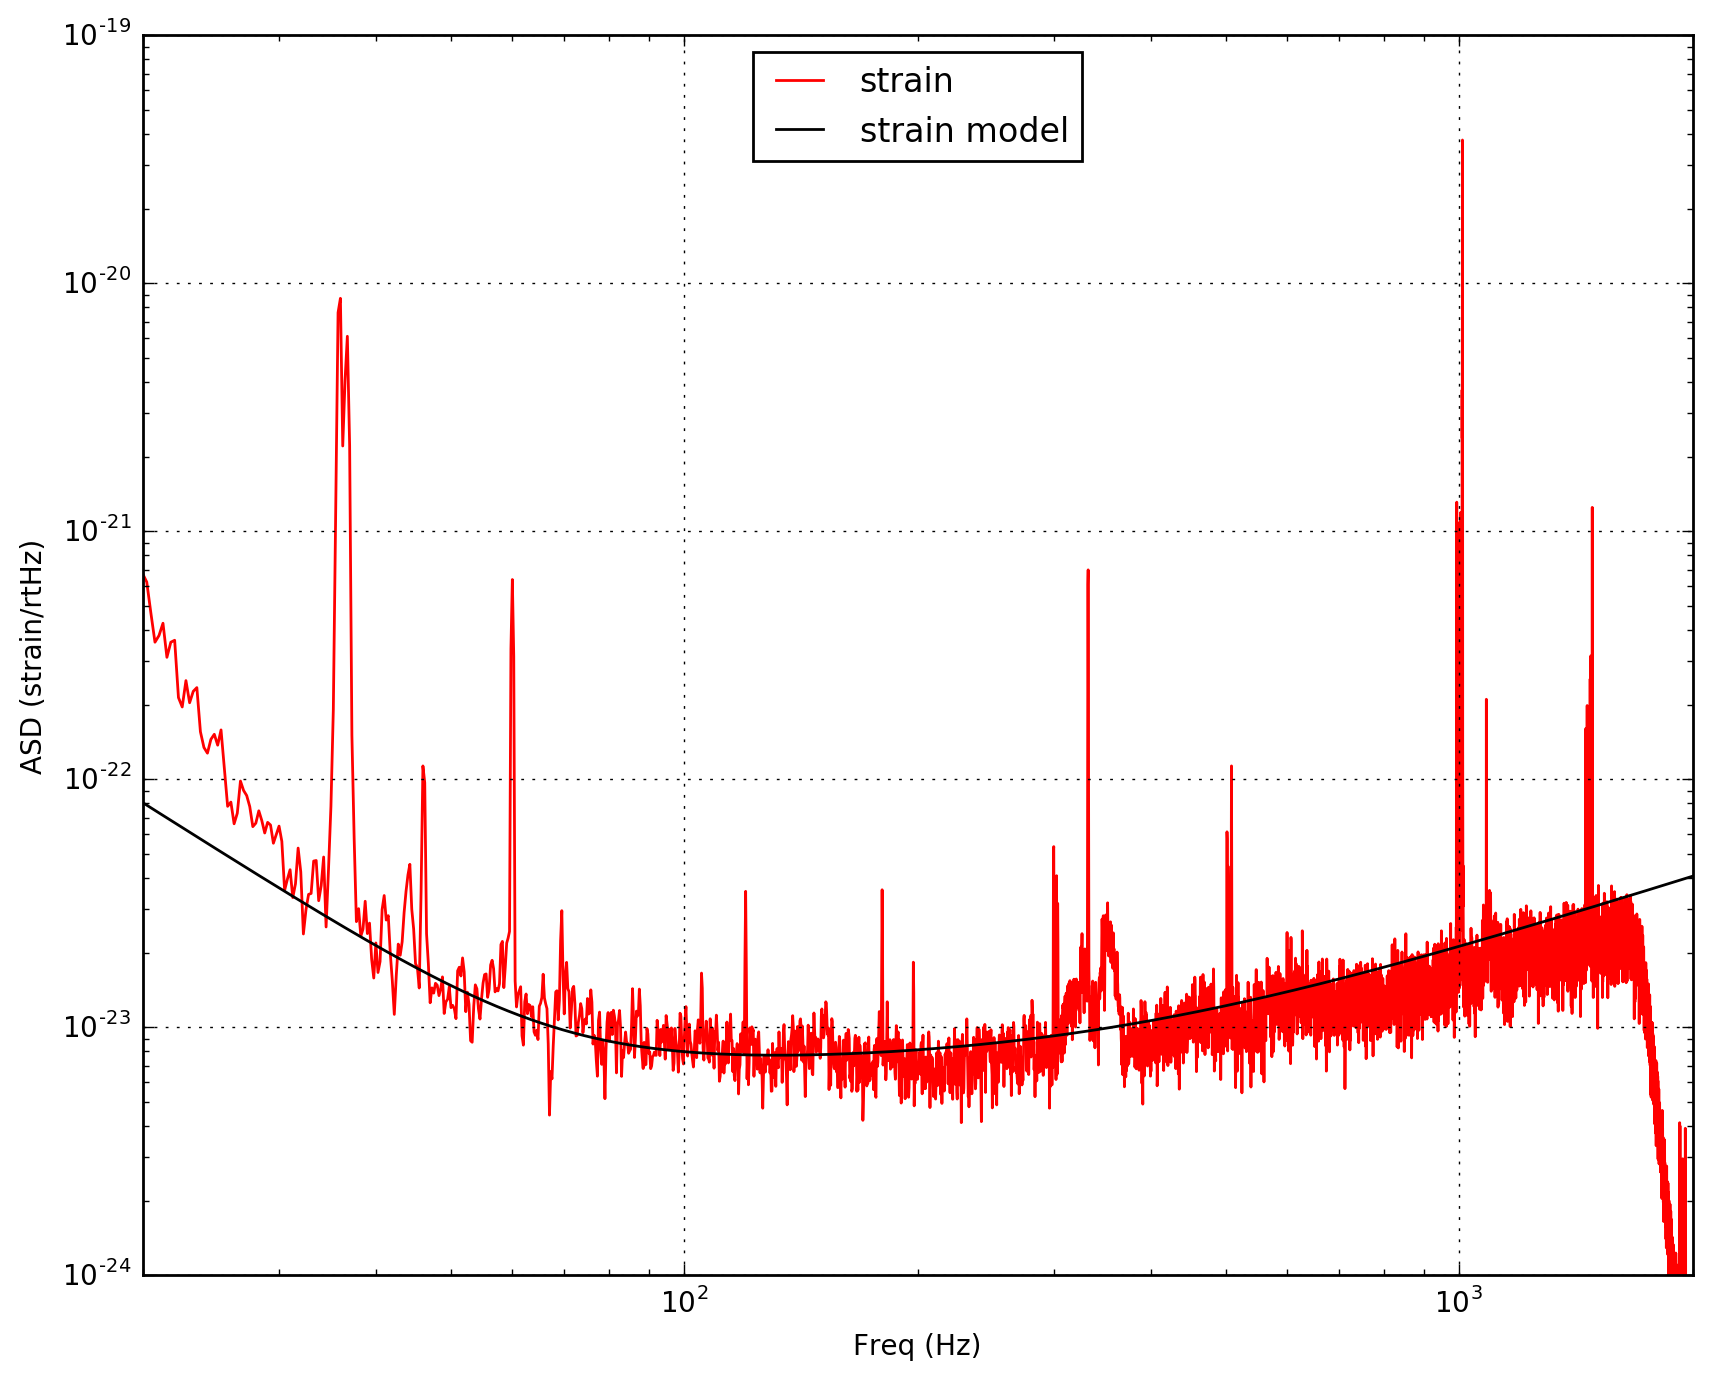

In [23]:
#capstone 1 and 2

time_series = ['H-H1_LOSC_4_V1-1128678884-32.hdf5', 
'H-H1_LOSC_4_V1-1135136334-32.hdf5', 'H-H1_LOSC_4_V1-1167559920-32.hdf5']

trefs = [(1.12867888e+09 + 1.12867892e+09)/2, (1.13513633e+09 + 1.13513637e+09)/2, (1.16755992e+09 + 1.16755995e+09)/2]
for i in range(3):
    strain, time = load_ligo_data(time_series[i])
    
    # we'll need the sample time step and frequency
    dt = time[1] - time[0]
    fs = int(1./dt)
    
    plt.figure()
    
    tref = trefs[i]
    
    plt.subplot(2,1,1)
    plt.plot(time-tref, strain, 'r', label='strain')
    plt.xlabel('time (s) since '+str(tref))
    plt.ylabel('strain')
    
    # now zoom in around the middle
    deltat = 5
    indxt = np.where((time >= tref-deltat) & (time < tref+deltat))
    
    plt.subplot(2,1,2)
    plt.plot(time[indxt], strain[indxt], 'r', label='strain')
    plt.xlabel('time (s) since '+str(tref))
    plt.ylabel('strain')
    
    # number of sample for the fast fourier transform:
    NFFT = 4*fs
    Pxx, freqs = mlab.psd(strain, Fs=fs, NFFT=NFFT)
    
    # Here is an approximate, smoothed PSD for H1 during O1, with no lines. We'll use it later.    
    Pxx_smooth = (1.e-22*(18./(0.1+freqs))**2)**2+0.7e-23**2+((freqs/2000.)*4.e-23)**2
    psd_smooth = interp1d(freqs, Pxx_smooth)
    
    # plot the ASDs, with the template overlaid:
    f_min = 20.
    f_max = 2000. 
    plt.figure(figsize=(10,8))
    plt.loglog(freqs, np.sqrt(Pxx),'r',label='strain')
    plt.loglog(freqs, np.sqrt(Pxx_smooth),'k',label='strain model')
    plt.axis([f_min, f_max, 1e-24, 1e-19])
    plt.grid('on')
    plt.ylabel('ASD (strain/rtHz)')
    plt.xlabel('Freq (Hz)')
    plt.legend(loc='upper center')

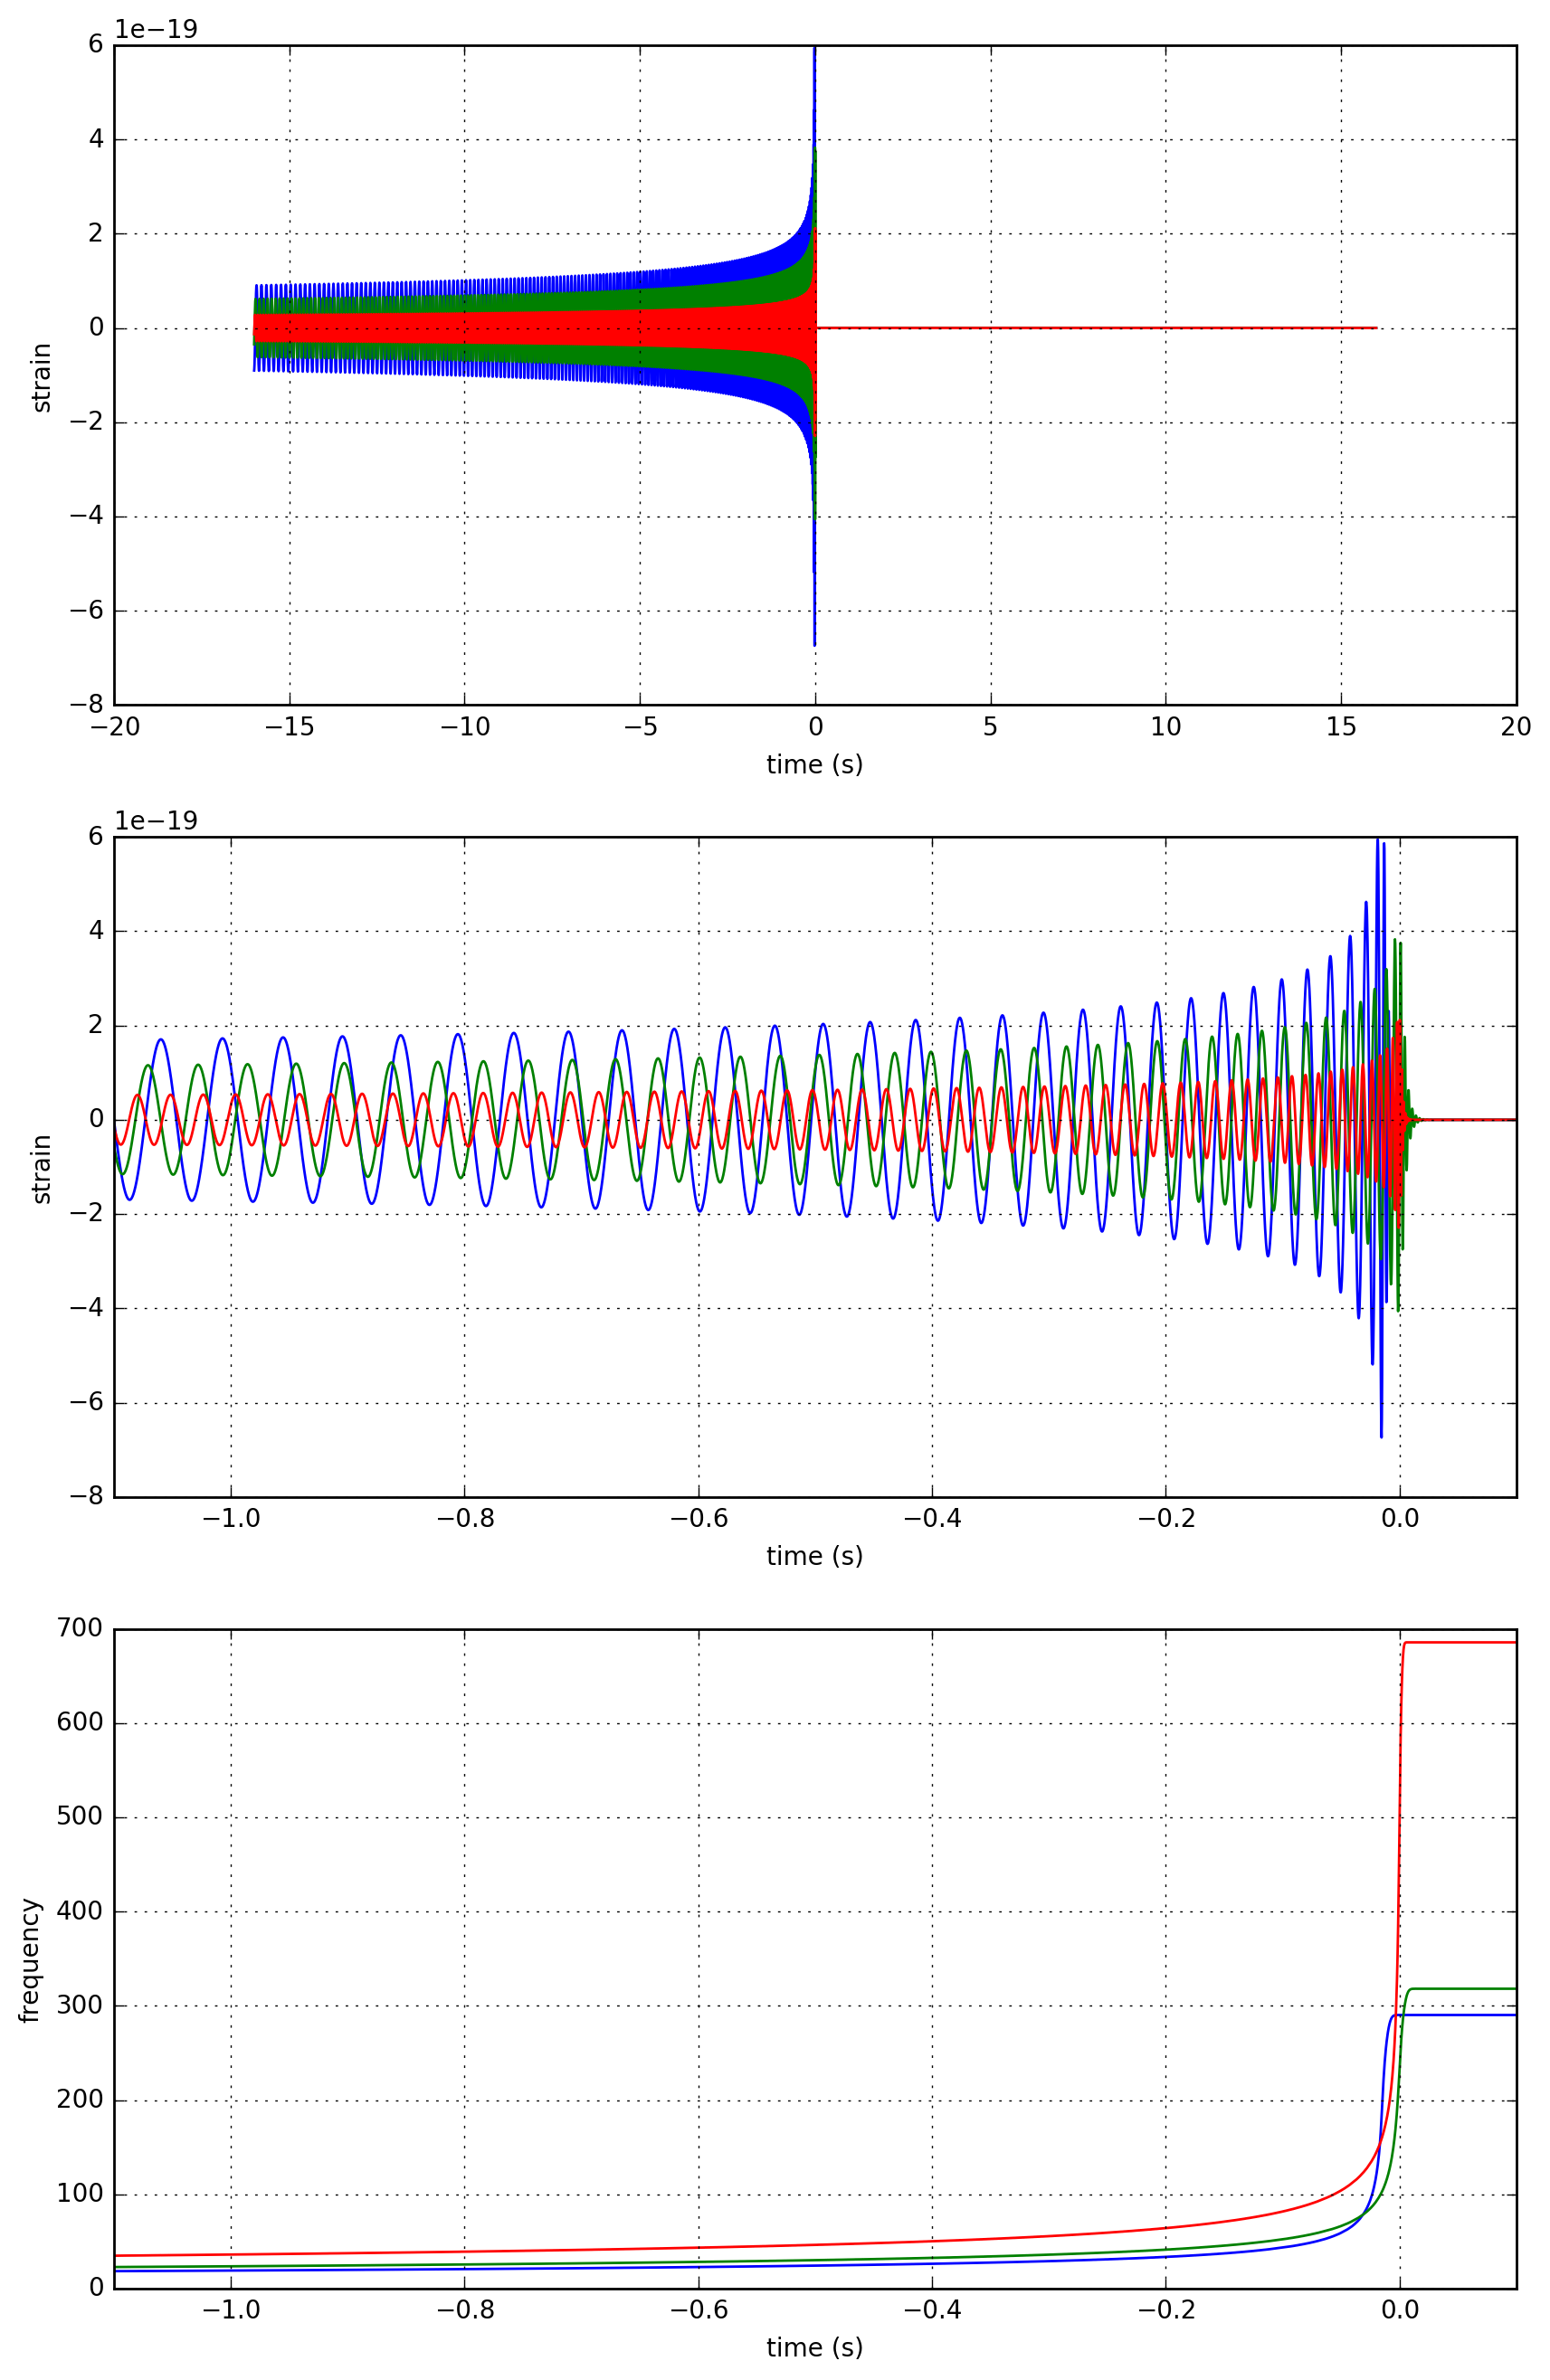

In [24]:
#capstone 3 and 4

templates = ['template_A.hdf5', 'template_B.hdf5', 'template_C.hdf5']

plt.figure(figsize=(10,16))

for i in range(3):
    template, ttime = load_template(templates[i]) 
    
    # calculate template frequency evolution
    tphase = np.unwrap(np.angle(template))
    fGW = np.gradient(tphase)*fs/(2.*np.pi)
    # fix discontinuities at the very end:
    # iffix = np.where(np.abs(np.gradient(fGW)) > 100.)[0]
    iffix = np.where(np.abs(template) < np.abs(template).max()*0.001)[0]
    fGW[iffix] = fGW[iffix[0]-1]
    fGW[np.where(fGW < 1.)] = fGW[iffix[0]-1]
    
    plt.subplot(3,1,1)
    plt.plot(ttime, np.real(template))
    plt.grid()
    plt.xlabel('time (s)')
    plt.ylabel('strain')
        
    plt.subplot(3,1,2)
    plt.plot(ttime, np.real(template))
    plt.xlim([-1.1, 0.1])
    plt.grid()
    plt.xlabel('time (s)')
    plt.ylabel('strain')
        
    plt.subplot(3,1,3)
    plt.plot(ttime, fGW)
    plt.xlim([-1.1, 0.1])
    plt.grid()
    plt.xlabel('time (s)')
    plt.ylabel('frequency')

maximum SNR: 7.836141326252687
event time: 1167559936.6083984
best fit template for: H-H1_LOSC_4_V1-1167559920-32.hdf5: template_A.hdf5
maximum SNR: 6.315891760828359
event time: 1128678900.4438477
best fit template for: H-H1_LOSC_4_V1-1128678884-32.hdf5: template_B.hdf5
maximum SNR: 9.631735467746728
event time: 1135136350.649414
best fit template for: H-H1_LOSC_4_V1-1135136334-32.hdf5: template_C.hdf5


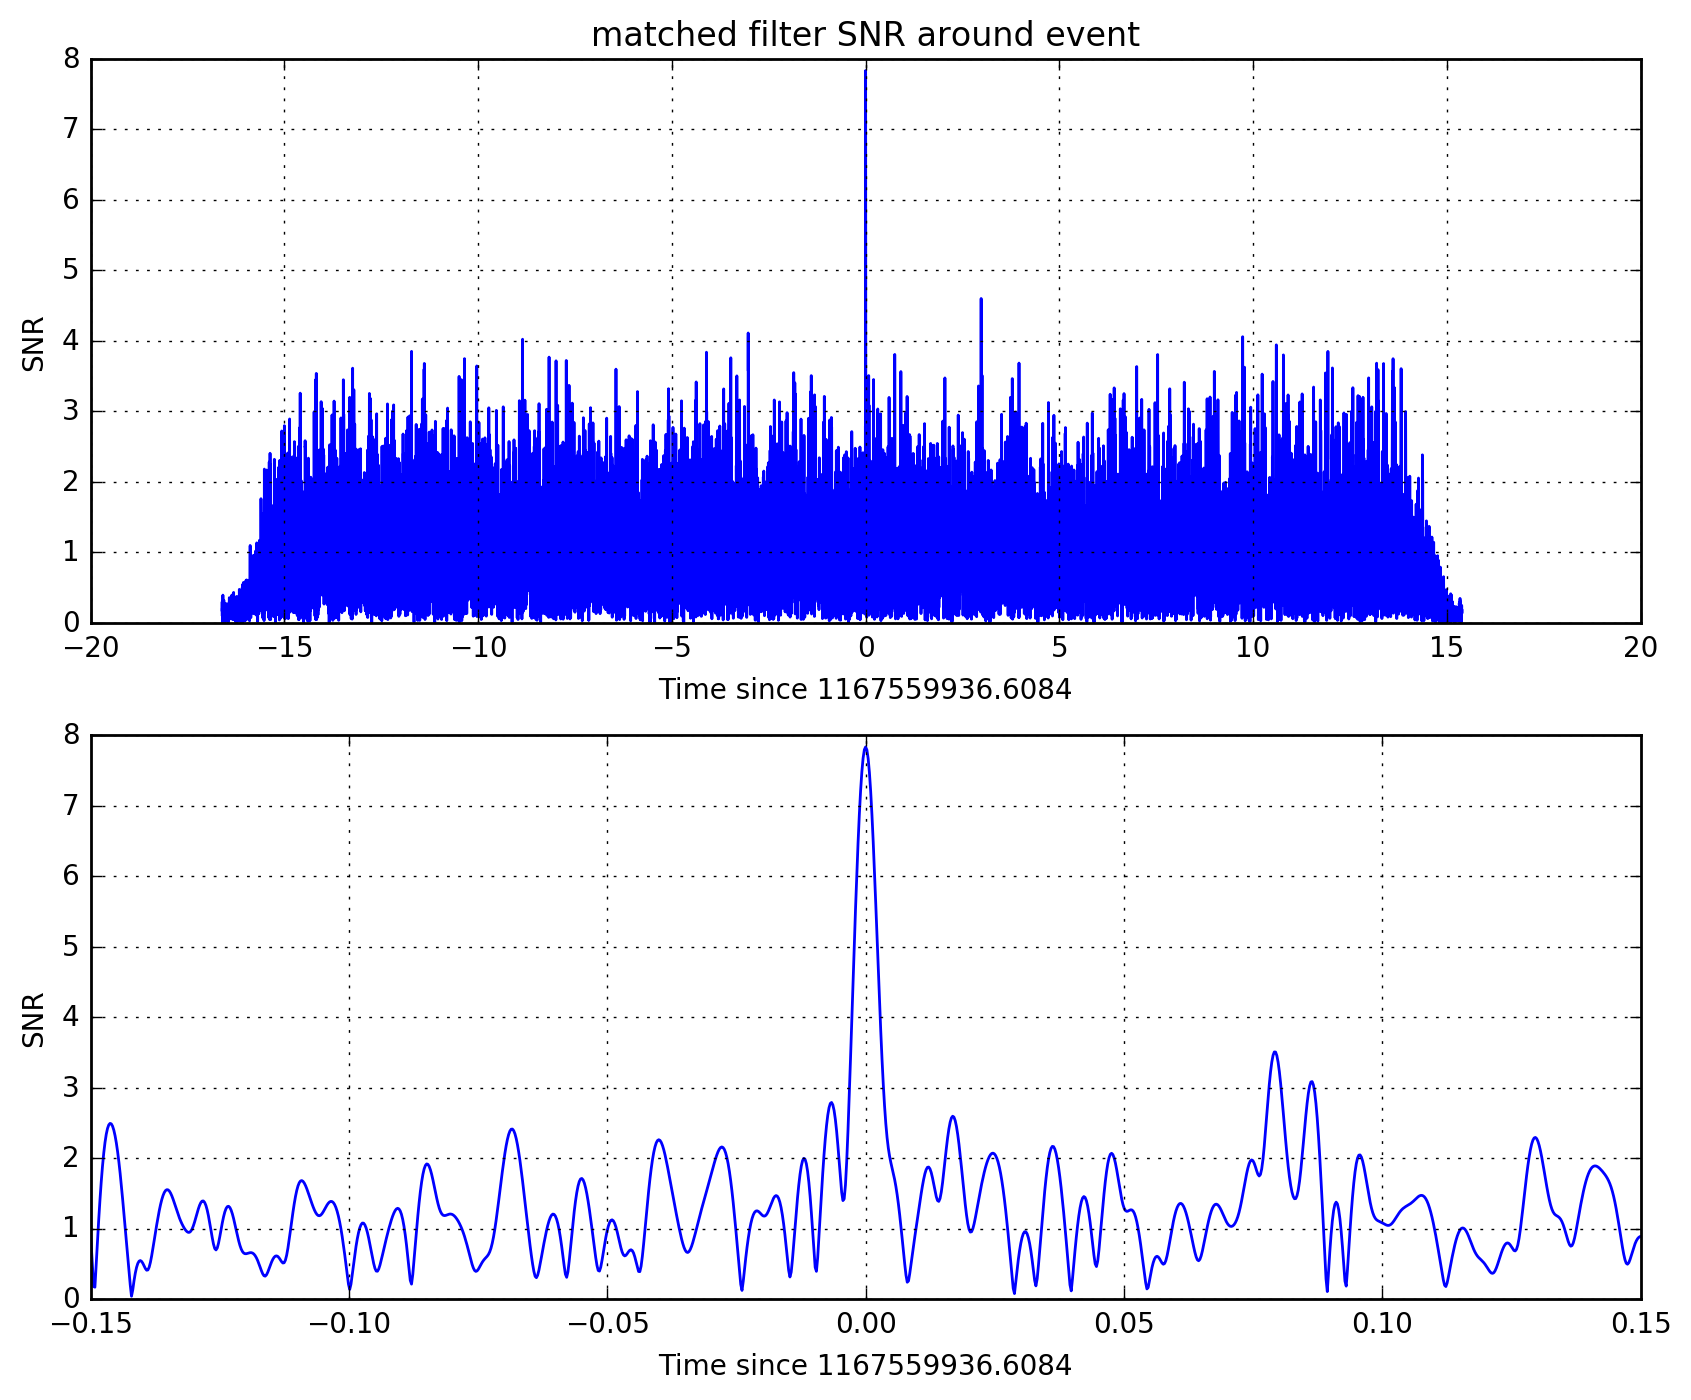

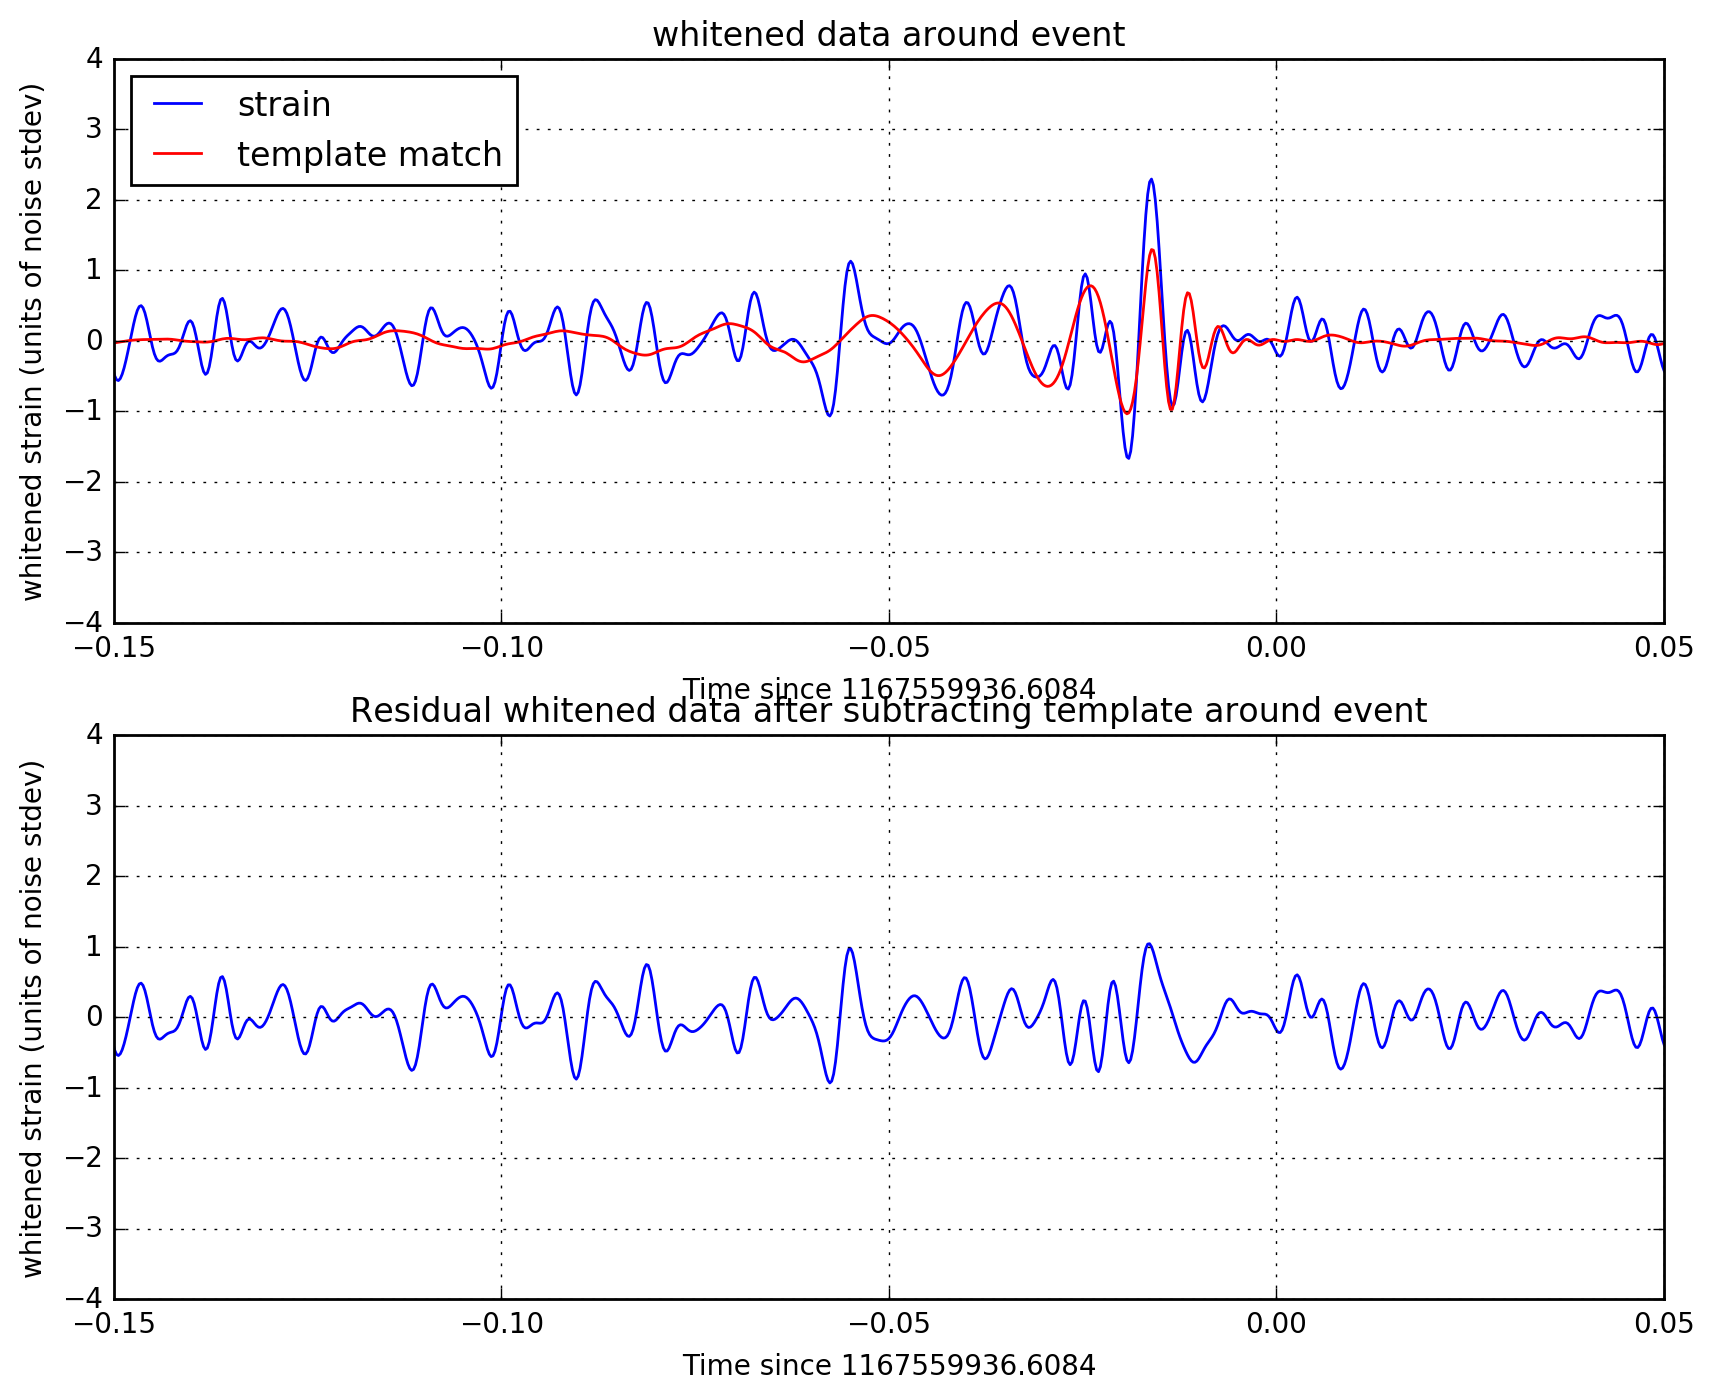

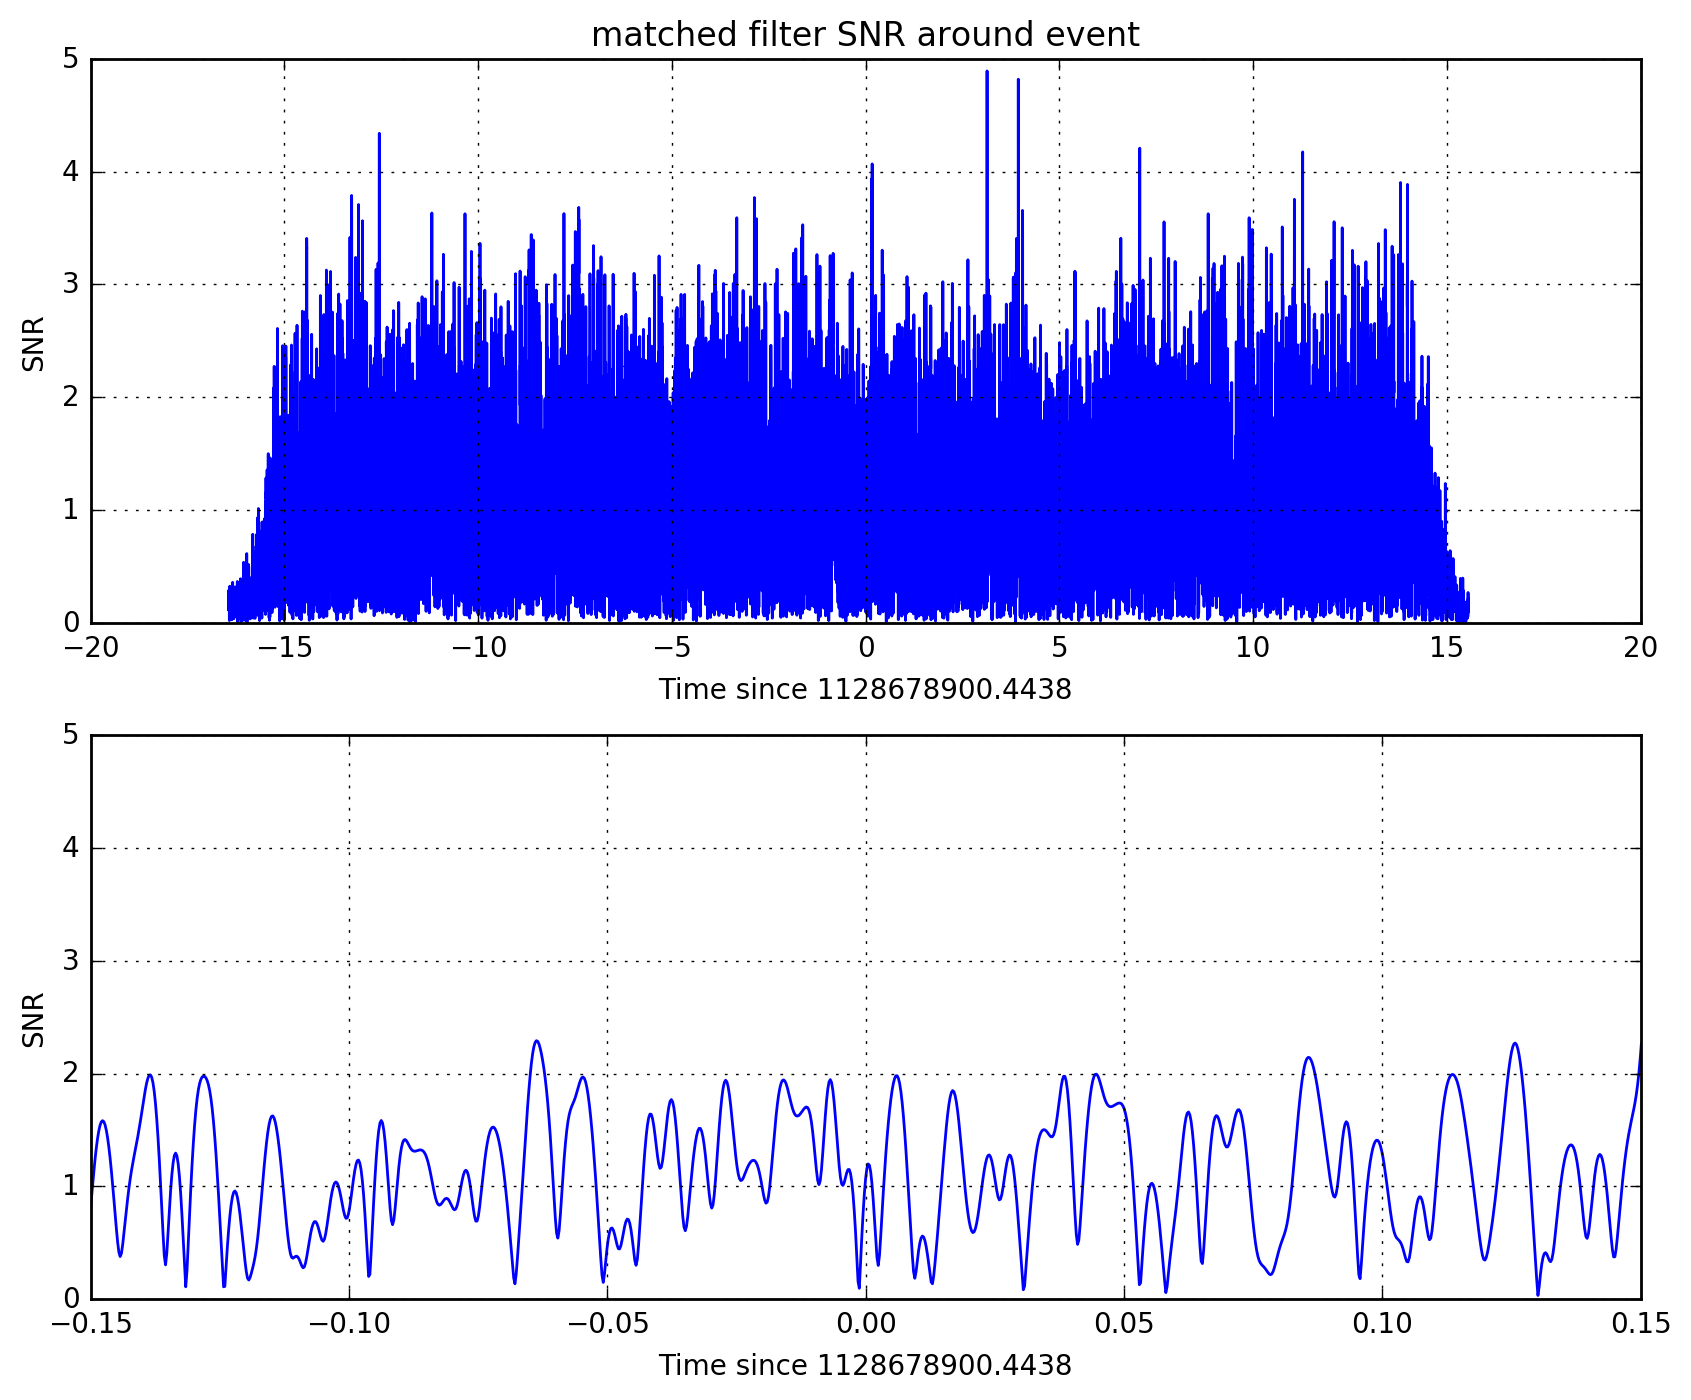

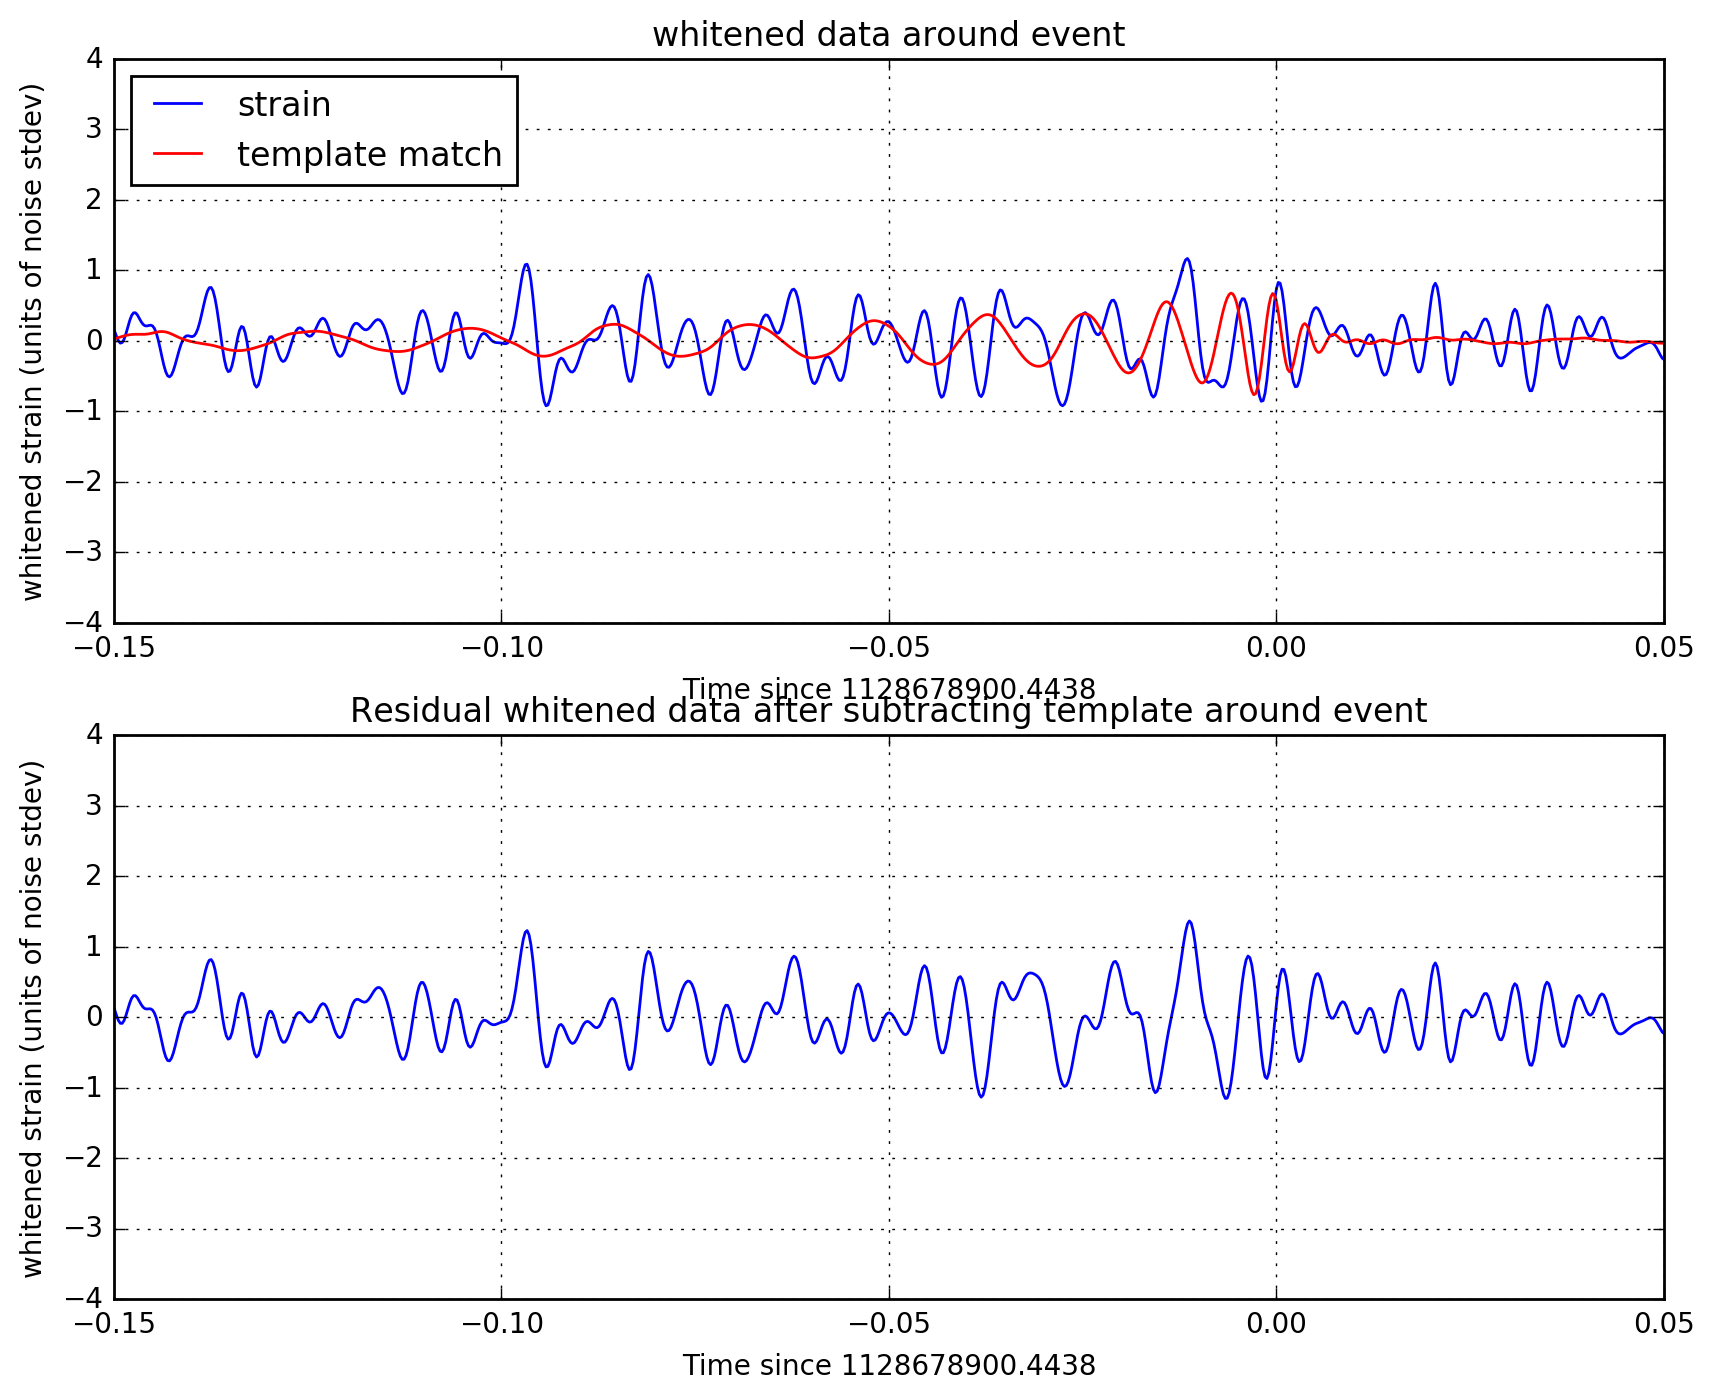

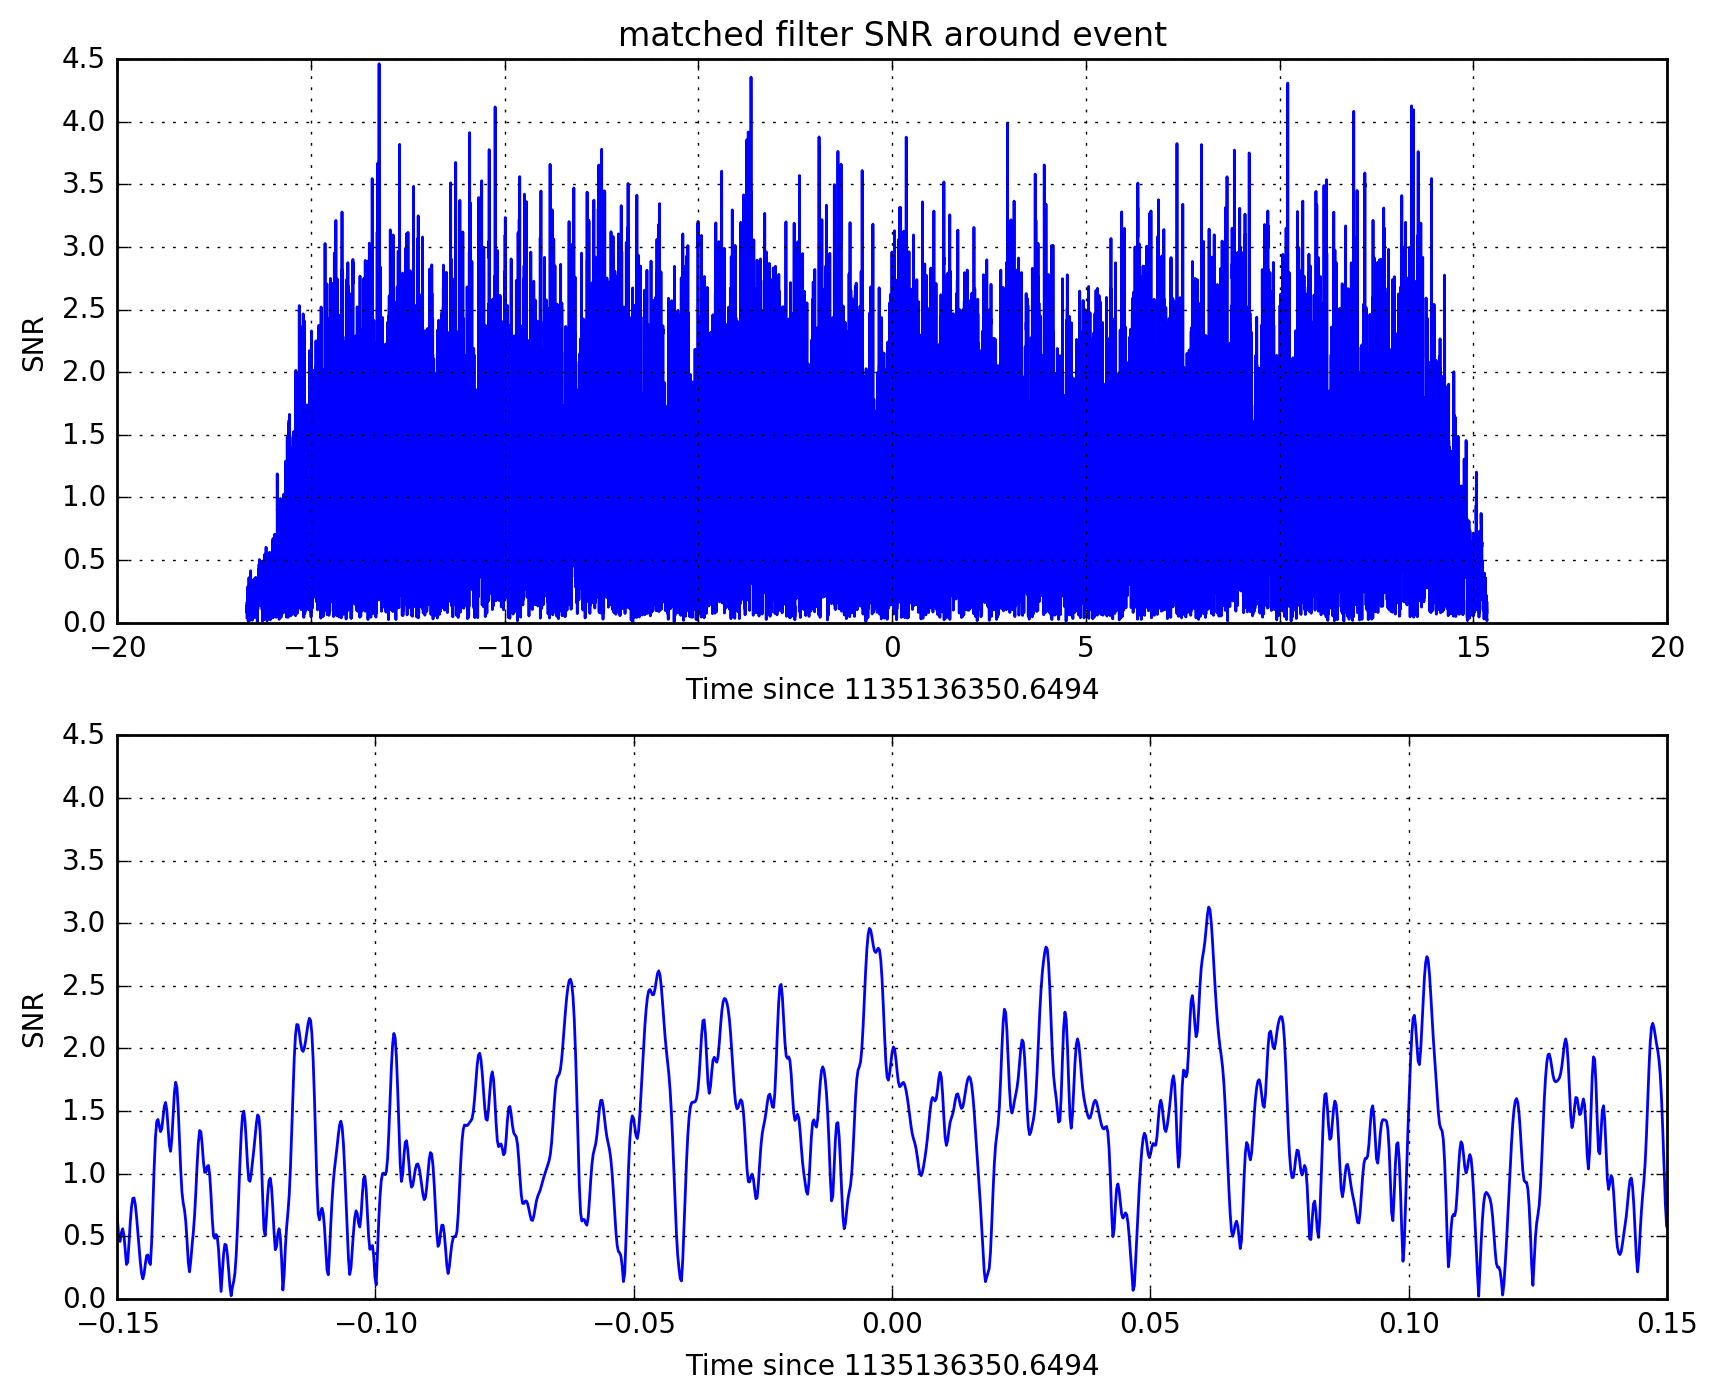

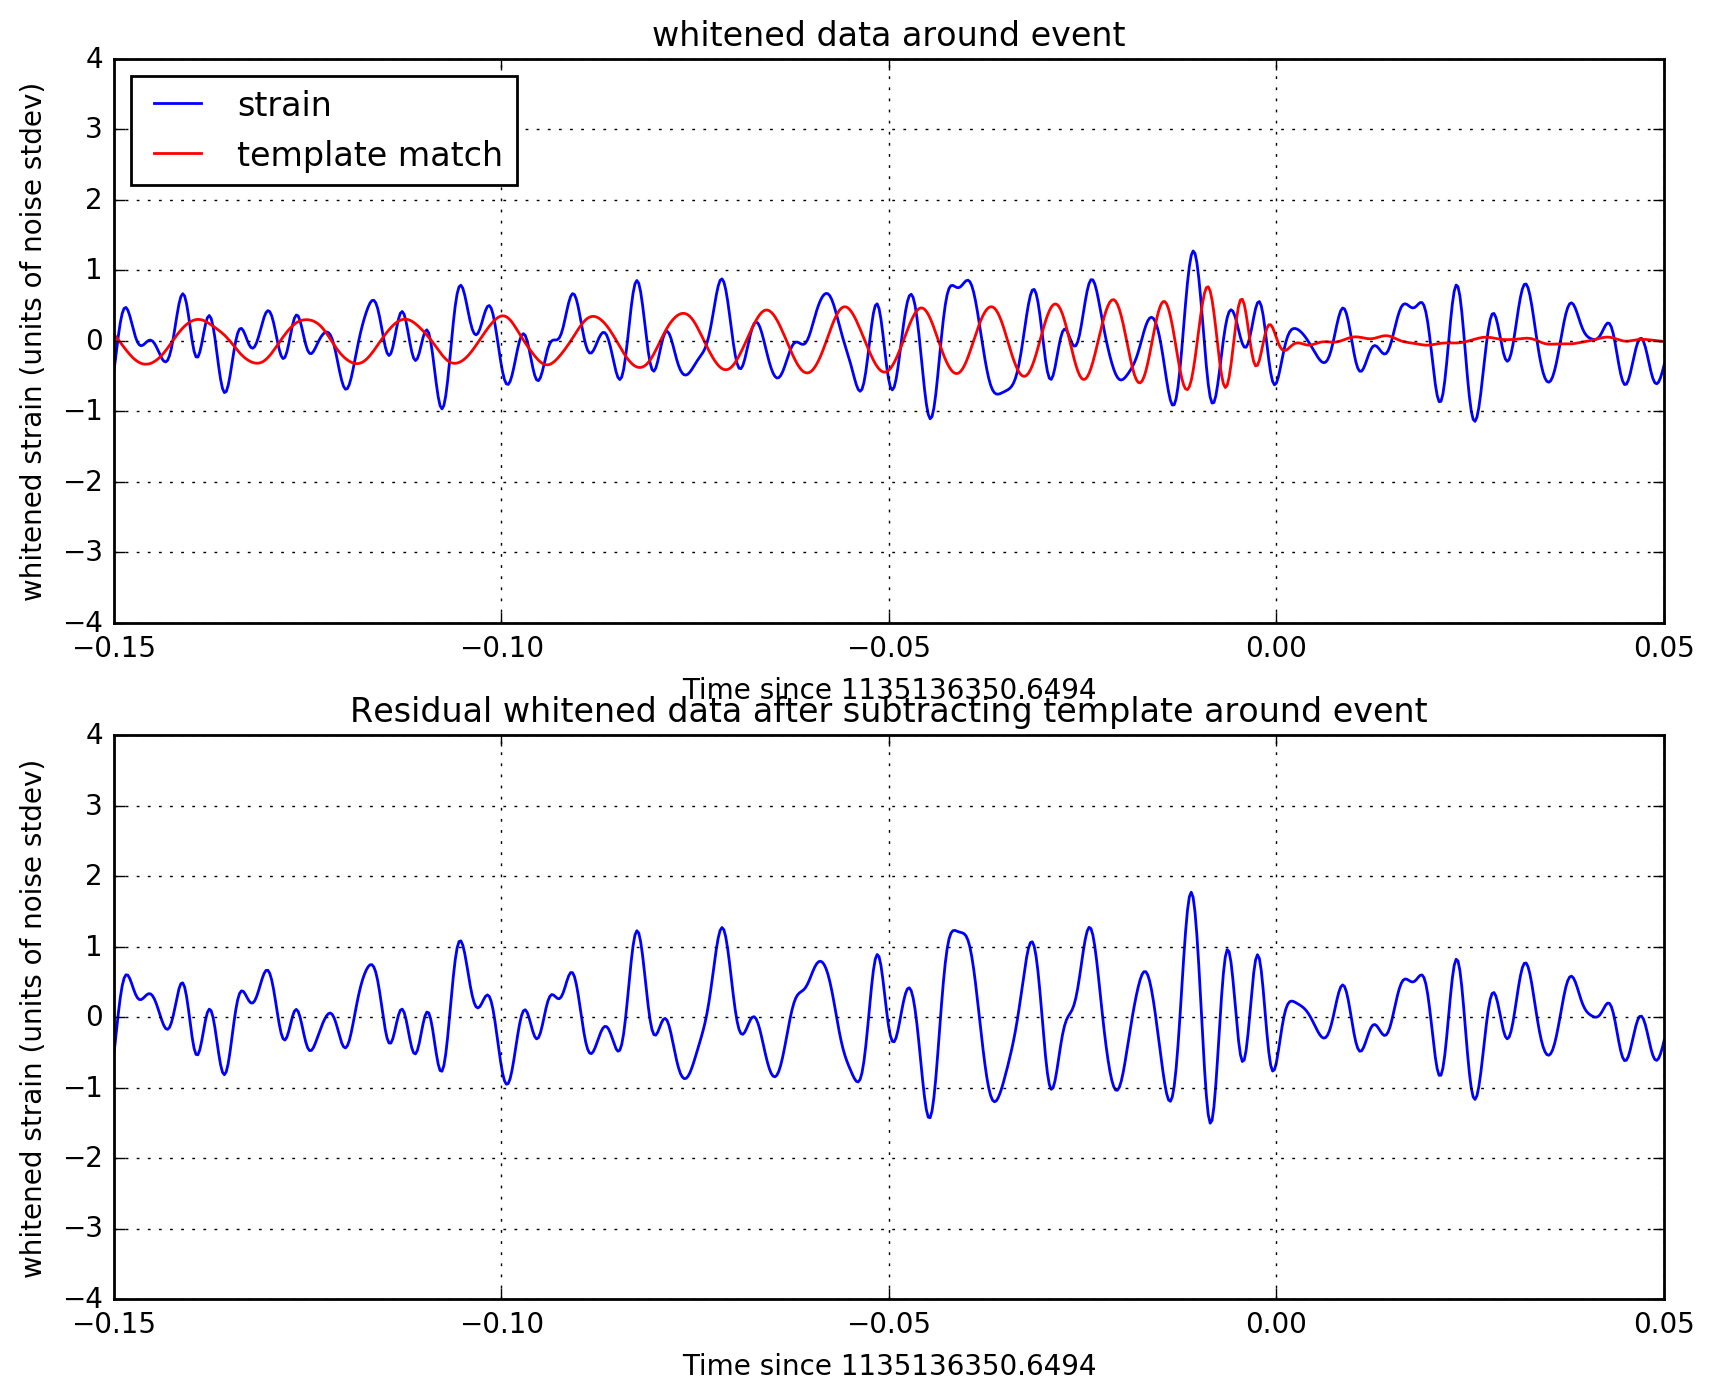

In [53]:
#capstone 5, 6, 7

#The directory contains three more chunks of LIGO data that are known to contain gravitational wave signals:
#5. use each template to create thee new matched filters
#6. search the three LIGO data chunks for signals with each of the three matched filters:
#What is the best matching template for each of the three data chunks?
#What is the time of each event?
#What is the SNR of each event?
#7. plot the best-fit templates against the data, and plot the residual
#Figure out the best fit phase and offset for each template "match".
#Whiten and band pass the strain data and the best fit template for each chunk.
#Plot the whitened/band-passed template and strain data on the same plot.
#Subtract the best-fit template from the strain and plot the residual.
#Show that the residual looks like regular noise.

templates = ['template_A.hdf5', 'template_B.hdf5', 'template_C.hdf5']
time_series = ['H-H1_LOSC_4_V1-1128678884-32.hdf5', 'H-H1_LOSC_4_V1-1135136334-32.hdf5', 'H-H1_LOSC_4_V1-1167559920-32.hdf5']

for i in range(3):
    template, ttime = load_template(templates[i]) 
    matched_filter = MatchedFilter(template, fs)
    maxSNRlist = []
    corrtimelist = []
    corrindmax = []
    for j in range(3):
        strain, time = load_ligo_data(time_series[j])
        SNR_complex, sigma = matched_filter.filter_data(strain, fs)
        SNR = abs(SNR_complex)
        indmax = np.argmax(SNR)
        timemax = time[indmax]
        SNRmax = SNR[indmax]
        maxSNRlist.append(SNRmax)
        corrindmax.append(indmax)
        corrtimelist.append(timemax)
    maxindex = maxSNRlist.index(max(maxSNRlist))
    print("maximum SNR: {}".format(maxSNRlist[maxindex]))
    print("event time: {}".format(corrtimelist[maxindex]))
    print("best fit template for: " + time_series[maxindex] + ": " + templates[i])
    tevent = corrtimelist[maxindex]
    SNRmax = maxSNRlist[maxindex]
    timemax = corrtimelist[maxindex]
    indmax = corrindmax[maxindex]
    strain, time = load_ligo_data(time_series[maxindex])
    
    whitening_filter = WhiteningFilter(strain, fs)
    bandpass_filter = BandPassFilter((43.0, 300.0))
    # we can calculate the "effective distance" from the max SNR (see FINDCHIRP paper for definition)
    # d_eff = (8. / SNRmax)*D_thresh
    d_eff = sigma / SNRmax
    
    # extract time offset and phase at peak
    phase = np.angle(SNR_complex[indmax])
    peaksample = int(strain.size / 2)
    offset = (indmax-peaksample)
    # whiten the strain data
    strain_whiten = whitening_filter.filter_data(strain, fs)
    strain_whitenbp = bandpass_filter.filter_data(strain_whiten, fs)
    #strain_whitenbp = bandpass_filter.filter_data(strain, fs)
    
    # whiten the template
    template_p_whiten = whitening_filter.filter_data(np.real(template), fs)
    template_c_whiten = whitening_filter.filter_data(np.imag(template), fs)
    template_p_whitenbp = bandpass_filter.filter_data(template_p_whiten, fs)
    template_c_whitenbp = bandpass_filter.filter_data(template_c_whiten, fs)
    #template_p_whitenbp = bandpass_filter.filter_data(template_p, fs)
    #template_c_whitenbp = bandpass_filter.filter_data(template_c, fs)
    # apply time offset, phase, and d_eff to the whitened template
    template_whitened = (template_p_whitenbp + template_c_whitenbp*1.j) 
    template_phaseshifted = np.real(template_whitened*np.exp(1j*phase)) ##prob
    template_match = np.roll(template_phaseshifted, offset) / d_eff  
    
    plt.figure(figsize=(10,8))
    plt.subplot(2,1,1)
    plt.plot(time-tevent, SNR)
    plt.grid('on')
    plt.ylabel('SNR')
    plt.xlabel('Time since {0:.4f}'.format(tevent))
    plt.title('matched filter SNR around event')
    
    # zoom in
    plt.subplot(2,1,2)
    plt.plot(time-tevent, SNR)
    plt.grid('on')
    plt.ylabel('SNR')
    plt.xlim([-0.15,0.15])
    plt.grid('on')
    plt.xlabel('Time since {0:.4f}'.format(tevent))

    plt.figure(figsize=(10,8))
    plt.subplot(2,1,1)
    plt.plot(time-tevent, strain_whitenbp, 'b', label='strain')
    plt.plot(time-tevent, template_match, 'r', label='template match')
    plt.ylim([-4, 4])
    #plt.ylim([-2e-21, 2e-21])
    plt.xlim([-0.15, 0.05])
    plt.grid('on')
    plt.xlabel('Time since {0:.4f}'.format(tevent))
    plt.ylabel('whitened strain (units of noise stdev)')
    plt.legend(loc='upper left')
    plt.title('whitened data around event')
    
    plt.subplot(2,1,2)
    plt.plot(time-tevent, strain_whitenbp-template_match)
    plt.ylim([-4, 4])
    #plt.ylim([-2e-21, 2e-21])
    plt.xlim([-0.15, 0.05])
    plt.grid('on')
    plt.xlabel('Time since {0:.4f}'.format(tevent))
    plt.ylabel('whitened strain (units of noise stdev)')
    plt.title('Residual whitened data after subtracting template around event')
